# Chipless RFID Tag Classification through Neural Networks
---
By: Cristina Aparicio González and Celia Noguerol Puente

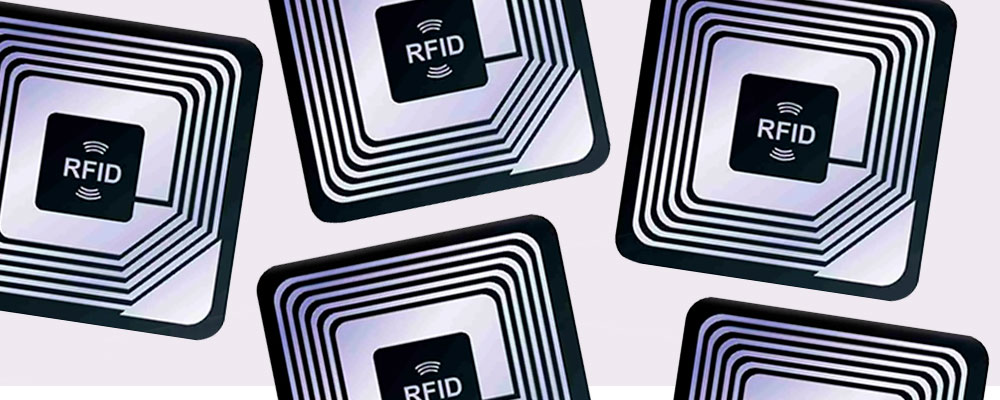

## Context and background
This notebook presents a dataset containing backscattered signals from **16 different Chipless RFID tags**, a promising technology for identification and sensing applications. Over the past two decades, extensive research has been dedicated to this technology, and it remains a highly active area of study. The measurements were collected at various distance ranges between the tag and the antenna (50-80 cm, 80-110 cm, 110-140 cm), with random manual inclinations applied during the measurements. Due to the simplicity of chipless RFID tags (which lack any electronics), the backscattered signals are highly sensitive to any source of distortion. **Traditional Digital Signal Processing** (DSP) techniques may not yield satisfactory results in extreme cases, which is why we combine DSP techniques with Machine Learning (ML) algorithms for classification in this study.

The measurements, which include both amplitude and phase information, were processed using the **Inverse Fourier Transform** (IFT) and time-gating, followed by the Continuous **Wavelet Transform** (CWT). The resulting output is a time-frequency domain representation of the signal, presented in an image-like format. Datasets of the resulting signals from 16 chipless RFID tags' backscattered signals are provided here.

In [ ]:
# Standard libraries
import os # For interacting with the operating system (file paths, directories).
import numpy as np # For numerical operations (arrays, matrices).
import pickle  # For saving and loading Python objects (like models, data).
import random  # For generating random numbers and shuffling data.
import re  # For working with regular expressions (text manipulation).
import matplotlib.pyplot as plt  # For creating visualizations (charts, graphs).
import seaborn as sns  # For creating beautiful statistical plots.
import pandas as pd  # For working with structured data (dataframes).
from tensorflow import keras  # High-level API for building deep learning models.
from keras import layers  # Contains different types of layers for neural networks.
from keras import models  # For defining and managing deep learning models.
from keras import regularizers # For adding regularization to layers (to prevent overfitting).
from sklearn.metrics import confusion_matrix  # For evaluating classification model performance.
from skimage.transform import resize # For resizing images.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the path to the project directory
path_files=''

# Create the 'logs' folder if it doesn't exist
if not os.path.exists('logs'):
    os.makedirs('logs')

# Create the 'models' folder if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

The **chipless RFID tags** are coded to have notches in the range 1.5 to 5 GHz. The frequency bandwidth is divided in the following five subbands:
1.5 - 2.3 - 2.8 - 3.4 - 4.2 - 5.

The backscattered signal can contain a notch or not in each subband. The presences of a notch is coded as '1' and the absence is coded as '0', leading to a binary code (e.g., 00100 would indicate a notch only in the subband 2.8 - 3.4).

The tags also have different sizes because the resonators are repeated in a matrix way. For example, a tag named 'tag_01110_3x3' has three notches in the subbands 2.3 - 2.8, 2.8 - 3.4 and 3.4 - 4.2; and the resonators used to make the tags are repeated in a 3x3 matrix shape.

The next function is used for illustration purposes. Given an input (s), the function deduces the subbands that contains **notches**.


In [4]:
def extract_notches_bounds(s):
    notches_bounds = np.array([1.52, 2.3, 2.8, 3.4, 4.2, 4.99])*10**9
    match = re.search(r'_(\d+)_', s)

    if match:
        code = match.group(1)

        # Convert to a NumPy array of booleans (1 -> True, 0 -> False)
        bool_array = np.array([bool(int(digit)) for digit in code])

        notches_indices = np.where(bool_array)[0]
        bounds_indices = set()
        for idx in notches_indices:
            bounds_indices.add(idx)
            bounds_indices.add(idx + 1)

        return notches_bounds[list(bounds_indices)]

---
## Datasets
There are 3 datasets. One made of measurements made in a very controlled environment. Two others made of measurements recorded in real-world environments. The latters are used to train and test the ML algorithms. The first one is used only for illustration purposes.

The datasets are stored as dictionaries saved as pickle (.pkl) files. The keys of the dictionnaries are:
- `images`: the CWT **output**
- `labels`: the tags names, what we want to **predict**
- `intervals`: the **distance** between the tag and the antenna
- `freq`: the **frequency** vector. Each initial measurement contains 1,601 samples that correspond to frequencies in the interval 1.5 - 5 GHz. For the purpose of this work they can be ommited.

The measurements made in the controlled environment are made at fixed distances.

### *Reference set*

As previously discussed, the following is the reference dataset, which consists of images acquired under controlled conditions.



In [ ]:
#Loading clean measurements (references)
with open(path_files + 'data' + 'cwt_references_final.pkl', 'rb') as file:
    data_ref = pickle.load(file)

In [6]:
images_ref = data_ref['images']
labels_ref = data_ref['labels']
interv_ref = data_ref['intervals']
frequences = data_ref['freq'].ravel()

We have 80 reference images, each with a resolution of **1601×57 pixels**.

In [7]:
# Number of images, height and width of the images
n, h, w = images_ref.shape

print(f'Number of reference images: {n}')
print(f'Height of the images: {h}')
print(f'Width of the images: {w}')

Number of reference images: 80
Height of the images: 1601
Width of the images: 57


Below is an example of one of the RFID tags we will be working with. The areas of high energy will be highlighted in yellow, while low-energy zones will be represented in blue.

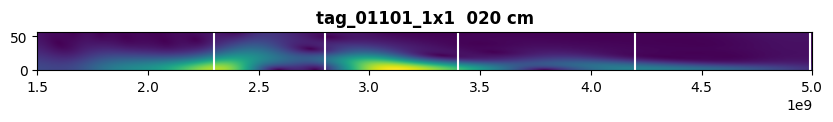

In [8]:
# A very ideal case
fig, ax = plt.subplots(figsize=(10,0.5))

# Visualización de la imagen del id especificado
idx = 60
ax.imshow(images_ref[idx].T, origin='lower', aspect='auto', extent=[frequences[0], frequences[-1], 0, w])
ax.set_title(labels_ref[idx] + '  ' + interv_ref[idx][-3:] + ' cm', fontsize=12, fontweight='bold')

notches = extract_notches_bounds(labels_ref[idx])

# Highlighting the expected notch frequencies
for vline in notches:
        ax.axvline(vline, color='white')

In this very ideal cases (very clean measurement, without interferences and/or noise) we can see how the CWT output looks like (for illustration purposes, here the image is transposed). The presented tag is `tag_01011_4x4`. The vertical white lines delimite the subbands where the notches should appear. The **notches** are represented as areas of low energy (blue color) withing an area of high energy (yellow color). In the image they appear as eliptical blue forms.


### *Training set*
In this section we illustrate some of the measurements obtained from a realistic set-up. In this case identifying a tag based on the backscattered signal gets more complicated due to environmental noise and intereferences.

In [ ]:
with open(path_files + 'data' + 'cwt_training_final.pkl', 'rb') as file:
    data_training = pickle.load(file)

In [10]:
images_training = data_training['images']
labels_training = data_training['labels']
interv_training = data_training['intervals']
frequences_training = data_training['freq'].ravel()

We have a training set of 4800 images, each with a resolution of **1601×57 pixels**.

In [11]:
N,H,W= images_training.shape
print(f'Number of reference images: {N}')
print(f'Height of the images: {H}')
print(f'Width of the images: {W}')

Number of reference images: 4800
Height of the images: 1601
Width of the images: 57


Below is an example of a training label from our dataset, where:

* **Yellow** regions indicate high energy
* **Blue** regions indicate low energy



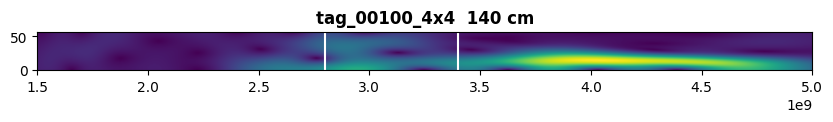

In [12]:
# Measurement in a real-world environment
fig, ax = plt.subplots(figsize=(10,0.5))

# Visualizing the tag with a specific ID
idx = random.randrange(images_training.shape[0])
ax.imshow(images_training[idx].T, origin='lower', aspect='auto', extent=[frequences[0], frequences[-1], 0, w])
ax.set_title(labels_training[idx] + '  ' + interv_training[idx][-3:] + ' cm', fontsize=12, fontweight='bold')

# Highlighting the expected notch frequencies
notches = extract_notches_bounds(labels_training[idx])
for vline in notches:
        ax.axvline(vline, color='white')

The training dataset has been collected to train AI models so that they can accurately predict a chiples RFID tag based on the collected backscattered signal in a real-world condition.

### *Test set*
The following set is used only for testing.

In [ ]:
with open(path_files + 'data' + 'cwt_testing_final_unlabeled.pkl', 'rb') as file:
    data_testing = pickle.load(file)

In [14]:
images_test = data_testing['images']

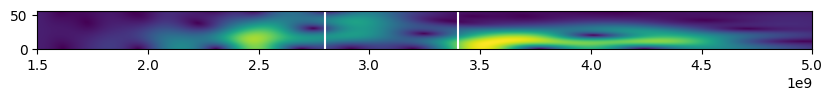

In [15]:
# Measurement in a real-world environment
fig, ax = plt.subplots(figsize=(10,0.5))

idx = random.randrange(images_test.shape[0])
ax.imshow(images_test[idx].T, origin='lower', aspect='auto', extent=[frequences[0], frequences[-1], 0, w])

# Highlighting the expected notch frequencies
for vline in notches:
        ax.axvline(vline, color='white')

## Preprocessing Pipeline for the Dataset

To ensure proper model performance, we **normalize** the image data by scaling pixel values to the range [0, 1]. Since these are standard images (with 8-bit pixel values), we simply divide each pixel by **255**.

In [16]:
# Normalize train and test images
images_training_norm = images_training / 255.0
images_test_norm = images_test / 255.0

Before training the models, we need to properly **format the labels**, as they are currently in a format like `tag_00001_4x4`. Only the numeric code (00001) is relevant for prediction, while the tag size (4x4) will be used later.

In [17]:
# Extract numeric codes and size tags from labels
label_codes = np.array([re.search(r"tag_(\d+)_", s).group(1) for s in labels_training])
label_sizes = np.array([re.search(r"_(\d+x\d+)$", s).group(1) for s in labels_training])

# Print results
print("Codes:", label_codes)
print("Sizes:", label_sizes)

Codes: ['11100' '11010' '11100' ... '11010' '01110' '01000']
Sizes: ['1x1' '3x3' '1x1' ... '3x3' '3x3' '2x2']


We've implemented label preprocessing to convert our target labels into a **one-hot encoded format** suitable for training classification models.

In [18]:
from sklearn.preprocessing import OneHotEncoder

# Convert binary strings to integer values
labels_indv = np.array([int(code, 2) for code in label_codes]).reshape(-1, 1)

# Apply One-Hot Encoding (creates a binary matrix per class)
encoder = OneHotEncoder(sparse_output=False)
labels_one_hot = encoder.fit_transform(labels_indv)

Now that our data is fully prepared, we can proceed with model **training**.

---
## Training of Deep Learning models

The first thing we are going to do is train **three convolutional neural networks** of different sizes and depths, in order to determine which one delivers the best performance when predicting the image tags. With that purpose, we will split our dataset into training, validation and test sets, using an approximate ratio of **70%** for training, **20%** for validation and **10%** for test. This will allow us to monitor the model’s performance on unseen data and help prevent overfitting.


In [19]:
# Determine the total number of samples in the dataset
total_samples = images_training_norm.shape[0]

# Split the dataset into training, validation, and test sets
train_size = int(total_samples * 0.7)  # 70% for training
val_size = int(total_samples * 0.2)    # 20% for validation
test_size = total_samples - train_size - val_size  # Remaining 10% for testing

# Split the images into their respective sets
train_img = images_training_norm[:train_size]
val_img = images_training_norm[train_size:train_size + val_size]
test_img = images_training_norm[train_size + val_size:]

# Split the labels accordingly
train_labels = labels_one_hot[:train_size]
val_labels = labels_one_hot[train_size:train_size + val_size]
test_labels = labels_one_hot[train_size + val_size:]

### Standard CNN Architectures



Three models have been trained, consisting of **2, 4, and 5 convolutional layers**, respectively. The goal is to verify whether deeper models are able to capture more complex features, potentially improving performance, although this also increases the risk of overfitting.

For each of these models, the following design choices have been applied:

- The number of **filters** has been progressively increased in each layer, allowing the network to learn increasingly complex patterns as depth grows.
- Larger **kernel sizes** have been used in the initial layers to better capture global patterns within the images.
- **Max pooling** layers have been introduced to reduce spatial dimensions, helping to decrease computational cost and mitigate overfitting.
- **ReLU** activation functions have been used in the hidden layers, and a **softmax** function has been applied in the output layer, as this is a multi-class classification problem.

***Simple Network*** - 2 Convolutional Layers

In [ ]:
# Definition of the architecture of the network
model_simple = models.Sequential()
model_simple.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(1601,57,1)))
model_simple.add(layers.MaxPooling2D((2, 2)))

model_simple.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_simple.add(layers.MaxPooling2D((2, 2)))

model_simple.add(layers.Flatten())
model_simple.add(layers.Dense(128, activation='relu'))
model_simple.add(layers.Dense(16, activation='softmax'))

model_simple.summary()

The model has been compiled using the **categorical crossentropy loss function**, as it is the most appropriate choice for multi-class classification problems where labels are one-hot encoded.

The **RMSprop optimizer** with a learning rate of 1e-4 has been selected because it adapts the learning rate for each parameter, making it well-suited for handling noisy gradients and non-stationary objectives — both common in deep learning tasks. The relatively small learning rate helps ensure stable and gradual convergence.

We track **accuracy** as the main evaluation metric, since it provides an intuitive measure of how well the model is performing.

The model is trained over **20 epochs** with a **batch size** of **128**, balancing training time and memory consumption. The validation set is used at the end of each epoch to monitor generalization performance and detect early signs of overfitting.

In [ ]:
# Compiling the model and starting the training process
model_simple.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
                    metrics=['accuracy'])

history_simple = model_simple.fit(train_img,
                                  train_labels,
                                  epochs=20,
                                  batch_size=128,
                                  validation_data=(val_img, val_labels))

# Saving the model and its history
model_simple.save(path_files + 'models/model_simple.h5')
with open(path_files + 'logs/history_simple.pkl', 'wb') as f:
    pickle.dump(history_simple.history, f)

***Intermediate Network*** - 4 Convolutional Layers

In [ ]:
# Definition of the architecture of the network
model_intermediate = models.Sequential()
model_intermediate.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(1601,57,1)))
model_intermediate.add(layers.MaxPooling2D((2, 2)))

model_intermediate.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_intermediate.add(layers.MaxPooling2D((2, 2)))

model_intermediate.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_intermediate.add(layers.MaxPooling2D((2, 2)))

model_intermediate.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_intermediate.add(layers.MaxPooling2D((2, 2)))

model_intermediate.add(layers.Flatten())
model_intermediate.add(layers.Dense(512, activation='relu'))
model_intermediate.add(layers.Dense(16, activation='softmax'))

model_intermediate.summary()

In [ ]:
# Compiling the model and starting the training process
model_intermediate.compile(loss='categorical_crossentropy',
                          optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
                          metrics=['accuracy'])

history_intermediate = model_intermediate.fit(train_img,
                                              train_labels,
                                              epochs=20,
                                              batch_size=128,
                                              validation_data=(val_img, val_labels))

# Saving the model and its history
model_intermediate.save(path_files + 'models/model_intermediate.h5')
with open(path_files + 'logs/history_intermediate.pkl', 'wb') as f:
    pickle.dump(history_intermediate.history, f)

***Depp Network*** - 5 Convolutional Layers

In [ ]:
# Definition of the architecture of the network
model_deep = models.Sequential()
model_deep.add(layers.Conv2D(32, (7, 7), activation='relu', padding='same', input_shape=(1601,57,1)))
model_deep.add(layers.MaxPooling2D((2, 2), padding='same'))

model_deep.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model_deep.add(layers.MaxPooling2D((2, 2), padding='same'))

model_deep.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_deep.add(layers.MaxPooling2D((2, 2), padding='same'))

model_deep.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model_deep.add(layers.MaxPooling2D((2, 2), padding='same'))

model_deep.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model_deep.add(layers.MaxPooling2D((2, 2), padding='same'))

model_deep.add(layers.Flatten())
model_deep.add(layers.Dense(512, activation='relu'))
model_deep.add(layers.Dense(256, activation='relu'))
model_deep.add(layers.Dense(16, activation='softmax'))

model_deep.summary()

In [ ]:
# Compiling the model and starting the training process
model_deep.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

history_deep = model_deep.fit(train_img,
                              train_labels,
                              epochs=20,
                              batch_size=128,
                              validation_data=(val_img, val_labels))


# Saving the model and its history
model_deep.save(path_files + 'models/model_deep.h5')
with open(path_files + 'logs/history_deep.pkl', 'wb') as f:
    pickle.dump(history_deep.history, f)

Throughout the study, we will **save** the trained models along with their histories, so that we can use them later without the need to retrain them.

In [ ]:
# Loading the models
model_simple = keras.models.load_model(path_files + 'models/model_simple.h5')
model_intermediate = keras.models.load_model(path_files + 'models/model_intermediate.h5')
model_deep = keras.models.load_model(path_files + 'models/model_deep.h5')

# Loading the models histories
with open(path_files + 'logs/history_simple.pkl', 'rb') as f:
    history_simple = pickle.load(f)

with open(path_files + 'logs/history_intermediate.pkl', 'rb') as f:
    history_intermediate = pickle.load(f)

with open(path_files + 'logs/history_deep.pkl', 'rb') as f:
    history_deep = pickle.load(f)

# Getting the max validation accuracy from each loaded history
model_simple_acc = max(history_simple['val_accuracy'])
model_intermediate_acc = max(history_intermediate['val_accuracy'])
model_deep_acc = max(history_deep['val_accuracy'])

Once the three models have been trained, we will visualize the **loss** and **accuracy** metrics obtained during training for both the training and validation sets. This will allow us to assess how well the models were trained and identify which one achieves the best performance. To make plotting more convenient, we have defined a function called `plot_training_histories`. By passing the training histories of the models to this function, it will automatically plot the accuracy and loss curves for each model.

In [27]:
import matplotlib.pyplot as plt

def plot_training_histories(histories, colors=None):
    """
    Plots the training and validation loss and accuracy curves for multiple models.

    Parameters:
    - histories (dict): Dictionary with model names as keys and Keras History objects as values.
    - colors (dict, optional): Dictionary with model names as keys and color hex codes as values.
    """
    if colors is None:
        # Default colors if none are provided
        default_colors = ['#1E3A8A', '#9B2C2C', '#3B82F6', '#16A34A', '#A21CAF']
        colors = {name: default_colors[i % len(default_colors)] for i, name in enumerate(histories.keys())}

    plt.figure(figsize=(11, 5))

    legend_lines = []
    legend_labels = []

    # Plot training and validation loss curves
    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        line_train, = plt.plot(history['loss'], label=f'{name} (Train)', color=colors[name])
        line_val, = plt.plot(history['val_loss'], '--', label=f'{name} (Val)', color=colors[name])

        # Store lines and labels for a unified legend
        legend_lines.extend([line_train, line_val])
        legend_labels.extend([f'{name} (Train)', f'{name} (Val)'])

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()

    # Plot training and validation accuracy curves
    plt.subplot(1, 2, 2)
    for name, history in histories.items():
        plt.plot(history['accuracy'], color=colors[name])
        plt.plot(history['val_accuracy'], '--', color=colors[name])

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()

    # Add a single, consolidated legend below the plots
    plt.figlegend(
        legend_lines,
        legend_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=len(histories) * 2 // 2
    )

    plt.tight_layout()
    plt.show()

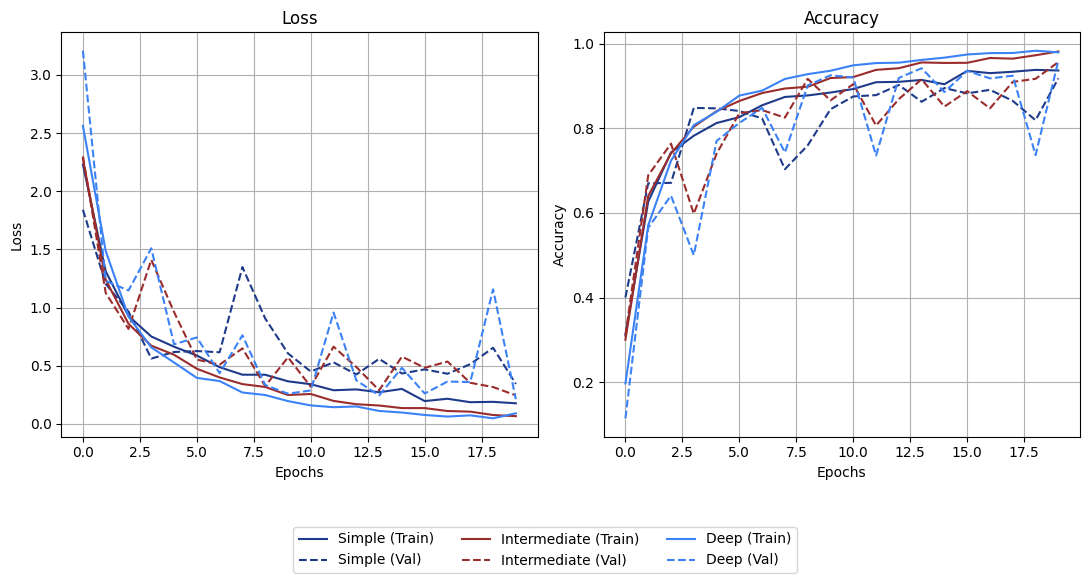

In [28]:
# Dictionary to store training histories
histories = {
    "Simple": history_simple,
    "Intermediate": history_intermediate,
    "Deep": history_deep
}

# Visualizing accuracy and loss
plot_training_histories(histories)

- **Loss plot**. All models exhibit a sharp decrease in training loss, which stabilizes after around 10 epochs. The validation loss follows a similar trend but fluctuates more, particularly for the Simple and Deep models. These fluctuations might be due to the batch size rather than a poor training process.

- **Accuracy plot**. The training accuracy increases steadily, reaching values close to 1.0. The validation accuracy follows a similar trend but shows some fluctuations, which could again be attributed to the batch size. Additionally, the fact that the validation curve begins to worsen compared to the training curve is a clear sign of **overfitting**. Therefore, in the following steps, strategies will be applied to the models to address and mitigate this issue.

Apparently, the **Deep model** achieves the highest accuracy and the best performance. However, to ensure that it is indeed the most suitable model to build upon and continue our study, we will extract **confusion matrices** and calculate additional **metrics** to evaluate how well it classifies the images.

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step


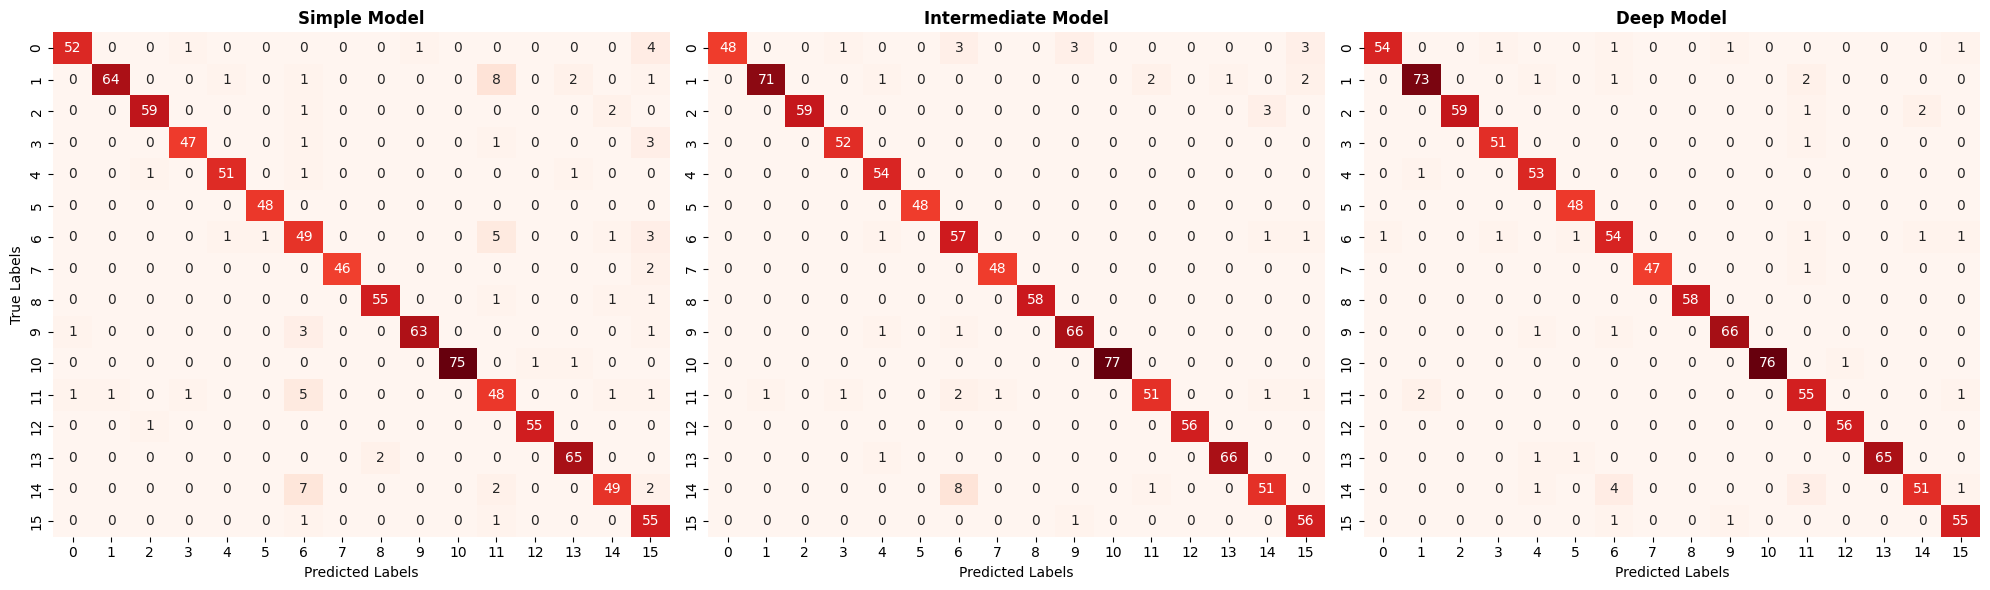

In [29]:
# Function to compute the confusion matrix for a given model
def get_confusion_matrix(model, val_img, val_labels):
    preds = model.predict(val_img)
    predicted_classes = preds.argmax(axis=-1)
    true_classes = val_labels.argmax(axis=-1)
    cm = confusion_matrix(true_classes, predicted_classes)
    return cm, np.unique(true_classes)

# Compute confusion matrices for all three models
cm_simple, class_names = get_confusion_matrix(model_simple, val_img, val_labels)
cm_intermediate, _ = get_confusion_matrix(model_intermediate, val_img, val_labels)
cm_deep, _ = get_confusion_matrix(model_deep, val_img, val_labels)

# Create a figure with subplots for visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot confusion matrix for the simple model
sns.heatmap(cm_simple, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, ax=axes[0])
axes[0].set_title('Simple Model', fontweight='bold')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Plot confusion matrix for the intermediate model
sns.heatmap(cm_intermediate, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, ax=axes[1])
axes[1].set_title('Intermediate Model', fontweight='bold')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('')

# Plot confusion matrix for the deep model
sns.heatmap(cm_deep, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, ax=axes[2])
axes[2].set_title('Deep Model', fontweight='bold')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

Based on the confusion matrices for each model, we can observe that as the model depth increases, classification errors decrease. This confirms that the **Deep Model** would be a good choice for further development.  

It is worth noting that all models struggle to classify label 14, frequently misclassifying it as 6. Similarly, label 1 is often predicted as 11, and label 0 as 15. This suggests that further investigation is needed to...  

Additionally, since the dataset includes images acquired at **different distances** (50-80 cm, 80-110 cm, and 110-140 cm), we aim to evaluate how well each model performs based on the acquisition distance. In principle, the 50-80 cm range should yield the best classification results, as the labels are closer to the sensor, leading to a better signal-to-noise ratio (SNR).  

To assess this, we will visualize the **confusion matrices** for each model and distance range and extract a set of metrics to quantify the classification performance in each case.

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 356ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 555ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


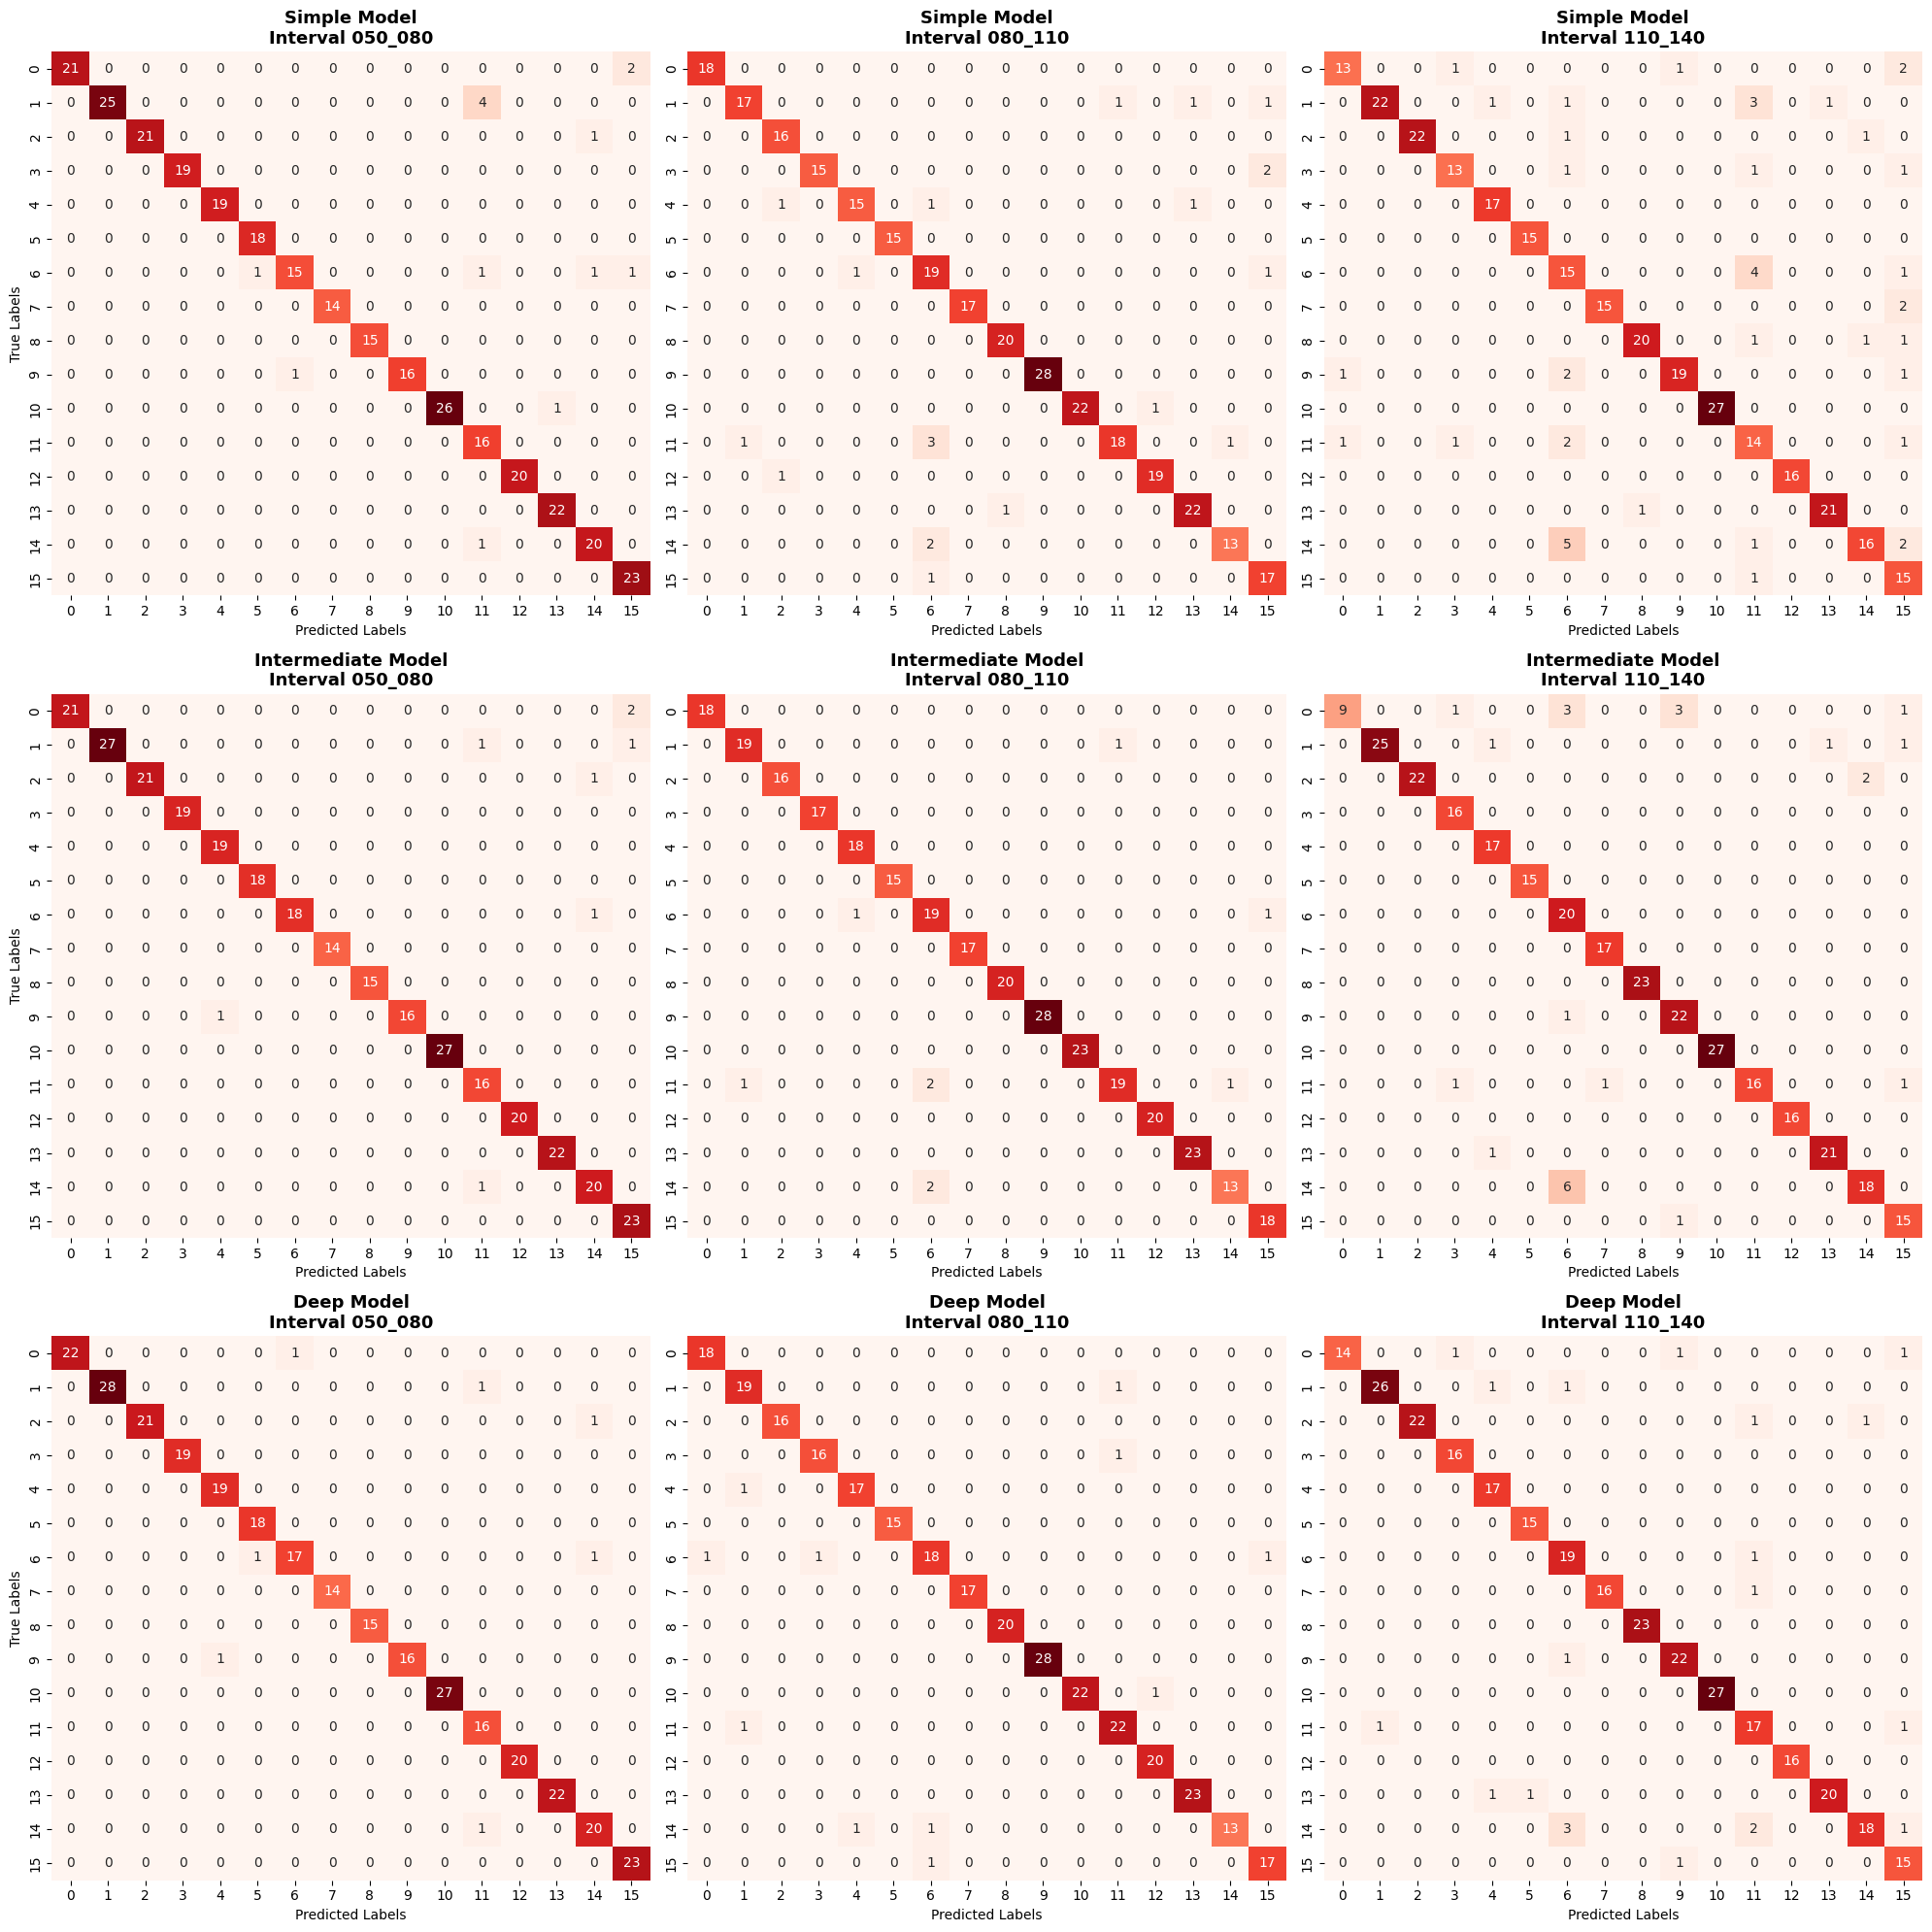

In [30]:
# Define validation set intervals
val_intervals = interv_training[train_size:train_size + val_size]

# Define interval categories
interval_values = ['050_080', '080_110', '110_140']

# Dictionary of trained models
trained_models = {
    'Simple Model': model_simple,
    'Intermediate Model': model_intermediate,
    'Deep Model': model_deep
}

# Function to compute the confusion matrix for a specific interval within the validation set
def get_cm_by_interval(model, images, labels, intervals, target_interval):
    mask = (intervals == target_interval)  # Filter samples belonging to the target interval
    images_interval = images[mask]
    labels_interval = labels[mask]

    preds = model.predict(images_interval)
    predicted_classes = preds.argmax(axis=-1)
    true_classes = labels_interval.argmax(axis=-1)
    cm = confusion_matrix(true_classes, predicted_classes)
    class_names = np.unique(true_classes)
    return cm, class_names

# Create a figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for row_idx, (model_name, model) in enumerate(trained_models.items()):
    for col_idx, interval in enumerate(interval_values):
        cm, class_names = get_cm_by_interval(
            model, val_img, val_labels, val_intervals, interval
        )
        ax = axes[row_idx, col_idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                    xticklabels=class_names, yticklabels=class_names,
                    cbar=False, ax=ax)
        ax.set_title(f'{model_name}\nInterval {interval}', fontsize=13, fontweight='bold')
        ax.set_xlabel('Predicted Labels')
        if col_idx == 0:
            ax.set_ylabel('True Labels')
        else:
            ax.set_ylabel('')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to compute model metrics for a given interval
def get_metrics_by_interval(model, images, labels, intervals, target_interval):
    mask = (intervals == target_interval)
    images_interval = images[mask]
    labels_interval = labels[mask]

    # Generate predictions
    preds = model.predict(images_interval)
    predicted_classes = preds.argmax(axis=-1)
    true_classes = labels_interval.argmax(axis=-1)

    # Compute metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted', zero_division=0)
    recall = recall_score(true_classes, predicted_classes, average='weighted', zero_division=0)
    f1 = f1_score(true_classes, predicted_classes, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1

# Dictionary to store metrics for each model and interval
metrics_dict = {}

# Compute metrics for each model and acquisition interval
for model_name, model in trained_models.items():
    model_metrics = []
    for interval in interval_values:
        accuracy, precision, recall, f1 = get_metrics_by_interval(
            model, val_img, val_labels, val_intervals, interval
        )
        model_metrics.append({
            'Interval': interval,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })
    metrics_dict[model_name] = pd.DataFrame(model_metrics)

# Display metrics tables for each model
for model_name, df in metrics_dict.items():
    print(f"\nMetrics for {model_name}:")
    display(df)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Metrics for Simple Model:


,Interval,Accuracy,Precision,Recall,F1-Score
0,050_080,0.956790,0.962908,0.956790,0.957349
1,080_110,0.932692,0.938310,0.932692,0.933141
2,110_140,0.864198,0.891128,0.864198,0.870636



Metrics for Intermediate Model:


,Interval,Accuracy,Precision,Recall,F1-Score
0,050_080,0.975309,0.977498,0.975309,0.975546
1,080_110,0.971154,0.971896,0.971154,0.970953
2,110_140,0.922840,0.935853,0.922840,0.921444



Metrics for Deep Model:


,Interval,Accuracy,Precision,Recall,F1-Score
0,050_080,0.978395,0.979507,0.978395,0.978496
1,080_110,0.964744,0.965317,0.964744,0.964586
2,110_140,0.935185,0.941245,0.935185,0.935431


In general, we can observe that as the model becomes **deeper** and more layers are added, **better results** are achieved across almost all metrics and intervals. This suggests that more complex models have a greater ability to capture patterns and generalize more effectively. Additionally, as expected, performance decreases as the distance between the tag and the sensor increases. This is because **greater measurement distances introduce more noise**, making it harder for the model to maintain accuracy.  

Furthermore, since the **tag size** is also encoded in their labels (1x1, 2x2, 3x3, and 4x4), we have also extracted the metrics for each model to evaluate their performance across different tag sizes. Similar to the previous case, larger tags should be classified more accurately, as they emit a stronger signal, leading to a lower signal-to-noise ratio (SNR).

In [32]:
# Function to get model metrics by tag size
def get_metrics_by_size(model, images, labels, sizes, target_size):
    # Create a mask for images corresponding to the target size
    mask = (sizes == target_size)
    images_size = images[mask]
    labels_size = labels[mask]

    # Make predictions
    preds = model.predict(images_size)
    predicted_classes = preds.argmax(axis=-1)
    true_classes = labels_size.argmax(axis=-1)

    # Calculate metrics with the zero_division parameter
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted', zero_division=0)
    recall = recall_score(true_classes, predicted_classes, average='weighted', zero_division=0)
    f1 = f1_score(true_classes, predicted_classes, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1

# Define the tag sizes (1x1, 2x2, 3x3, 4x4)
sizes = np.array([re.search(r"_(\d+x\d+)$", label).group(1) for label in labels_training])
unique_sizes = np.unique(sizes)

# Create a dictionary to store metrics by size and model
metrics_dict = {}

# For each model, calculate metrics by tag size
for model_name, model in trained_models.items():
    model_metrics = []
    for size in unique_sizes:
        # Use val_img and val_labels for validation
        accuracy, precision, recall, f1 = get_metrics_by_size(
            model, val_img, val_labels, sizes[train_size:train_size + val_size], size
        )
        model_metrics.append({
            'Size': size,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })
    metrics_dict[model_name] = pd.DataFrame(model_metrics)

# Display the tables for each model
for model_name, df in metrics_dict.items():
    print(f"\nMetrics for {model_name}:")
    display(df)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 531ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 509ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 472ms/step

Metrics for Simple Model:


,Size,Accuracy,Precision,Recall,F1-Score
0,1x1,0.855319,0.877337,0.855319,0.864457
1,2x2,0.912052,0.996617,0.912052,0.951586
2,3x3,0.965217,1.000000,0.965217,0.982292
3,4x4,0.953795,1.000000,0.953795,0.976060



Metrics for Intermediate Model:


,Size,Accuracy,Precision,Recall,F1-Score
0,1x1,0.914894,0.939148,0.914894,0.924734
1,2x2,0.973941,0.993718,0.973941,0.983328
2,3x3,0.991304,1.000000,0.991304,0.995619
3,4x4,0.957096,1.000000,0.957096,0.976868



Metrics for Deep Model:


,Size,Accuracy,Precision,Recall,F1-Score
0,1x1,0.914894,0.944174,0.914894,0.928291
1,2x2,0.973941,0.990214,0.973941,0.981903
2,3x3,0.973913,1.000000,0.973913,0.986779
3,4x4,0.973597,1.000000,0.973597,0.986429


Our suspicions have been confirmed, as we can observe that as the label size increases, the models' classification performance improves due to a better SNR relationship. Once again, the **Deep model** consistently provides the best classification results overall. Therefore, we will proceed with implementing a series of adjustments to mitigate the model's **overfitting**.

---
### Strategies to Avoid Overfitting

To prevent overfitting, various techniques can be applied, such as increasing the training dataset, performing data augmentation, regularizing, or adding dropout layers. In our case, since we do not have more data and cannot perform data augmentation due to the nature of the problem we are solving (as modifying the images could result in incorrect predictions of frequency bands), we will proceed with **L2 regularization** (Ridge) and adding **dropout layers**.

***Ridge regularization***

To add Ridge regularization, we will introduce a set of "constraints" on the model during training, which will help prevent it from overfitting to the training data, allowing it to generalize correctly. To do this, we simply need to add a `regularizers` argument to each of the layers of the model, which is included in the Keras library.

In [ ]:
l2_lambda = 0.001  # L2 regularization parameter

model_l2 = models.Sequential()
model_l2.add(layers.Conv2D(32, (7, 7), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(1601,57,1)))
model_l2.add(layers.MaxPooling2D((2, 2), padding='same'))

model_l2.add(layers.Conv2D(64, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), padding='same'))
model_l2.add(layers.MaxPooling2D((2, 2), padding='same'))

model_l2.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), padding='same'))
model_l2.add(layers.MaxPooling2D((2, 2), padding='same'))

model_l2.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), padding='same'))
model_l2.add(layers.MaxPooling2D((2, 2), padding='same'))

model_l2.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), padding='same'))
model_l2.add(layers.MaxPooling2D((2, 2), padding='same'))

model_l2.add(layers.Flatten())
model_l2.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
model_l2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
model_l2.add(layers.Dense(16, activation='softmax'))

model_l2.summary()


In [ ]:
# Compiling the model and starting the training process
model_l2.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

history_l2 = model_l2.fit(train_img,
                          train_labels,
                          epochs=20,
                          batch_size=128,
                          validation_data=(val_img, val_labels))

# Saving the model and its history
model_l2.save(path_files + 'models/model_l2.h5')
with open(path_files + 'logs/history_l2.pkl', 'wb') as f:
    pickle.dump(history_l2.history, f)

In [ ]:
# Load model
model_l2 = keras.models.load_model(path_files + 'models/model_l2.h5')

# Loading the models histories
with open(path_files + 'logs/history_l2.pkl', 'rb') as f:
    history_l2 = pickle.load(f)

# Getting the max validation accuracy from each loaded history
model_l2_acc = max(history_l2['val_accuracy'])

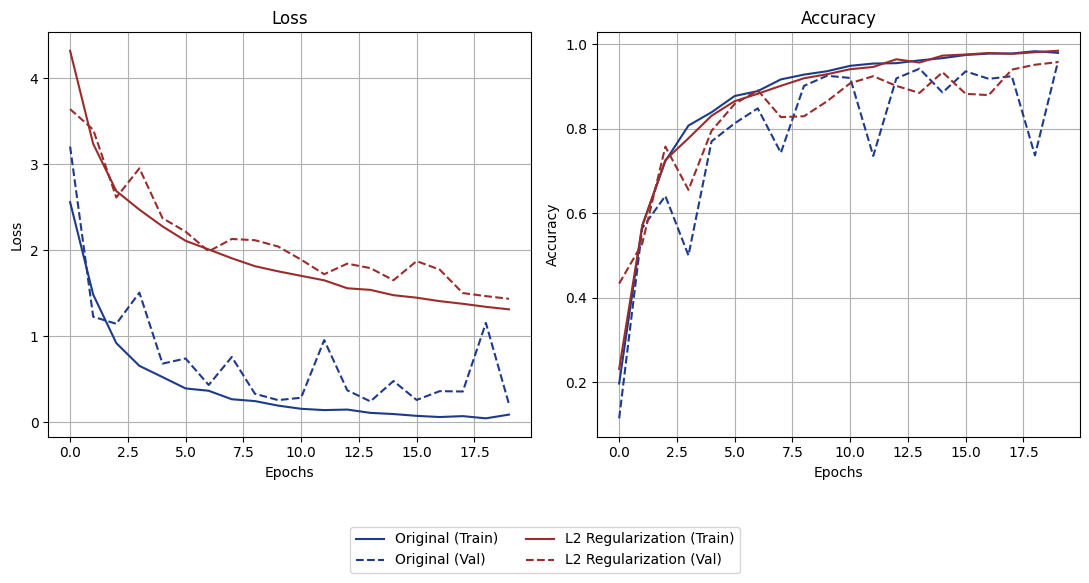

In [36]:
# Dictionary to store training histories
histories = {
    "Original": history_deep,
    "L2 Regularization": history_l2
}

# Visualizing accuracy and loss
plot_training_histories(histories)

The accuracy and loss results show that by adding regularization, the model slightly alleviates the overfitting issue, as the validation curve gets closer to the training curve. However, the **problem still persists**, so we will try another strategy: adding dropout layers. **Dropout** works by randomly "dropping out" a fraction of neurons during training, which helps prevent the model from relying too much on specific neurons, promoting better generalization. This approach can be particularly effective when combined with L2 regularization.

***Dropout layers***

Dropout layers will **deactivate** a certain percentage of the **neurons** in a given layer, so that the model does not learn all neurons in the same way. The goal is to encourage better generalization of what it learns from the data. In terms of code, it's as simple as adding an additional `Dropout` layer to the model in the layer we choose.

In [ ]:
# Model with Dropout
model_dropout = models.Sequential()
model_dropout.add(layers.Conv2D(32, (7, 7), activation='relu', padding='same', input_shape=(1601,57,1)))
model_dropout.add(layers.MaxPooling2D((2, 2), padding='same'))

model_dropout.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model_dropout.add(layers.MaxPooling2D((2, 2), padding='same'))

model_dropout.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_dropout.add(layers.MaxPooling2D((2, 2), padding='same'))

model_dropout.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model_dropout.add(layers.MaxPooling2D((2, 2), padding='same'))

model_dropout.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model_dropout.add(layers.MaxPooling2D((2, 2), padding='same'))

model_dropout.add(layers.Flatten())
model_dropout.add(layers.Dense(512, activation='relu'))
model_dropout.add(layers.Dense(256, activation='relu'))
model_dropout.add(layers.Dropout(0.5))  # 50% dropout
model_dropout.add(layers.Dense(16, activation='softmax'))

model_dropout.summary()

In [ ]:
# Compiling the model and starting the training process
model_dropout.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

history_dropout = model_dropout.fit(train_img,
                                    train_labels,
                                    epochs=20,
                                    batch_size=128,
                                    validation_data=(val_img, val_labels))

# Saving the model and its history
model_dropout.save(path_files + 'models/model_dropout.h5')
model_dropout.save_weights(path_files + 'models/model_dropout.weights.h5')
with open(path_files + 'logs/history_dropout.pkl', 'wb') as f:
    pickle.dump(history_dropout.history, f)

In [ ]:
# Load the model
model_dropout = keras.models.load_model(path_files + 'models/model_dropout.h5')

# Loading the models histories
with open(path_files + 'logs/history_dropout.pkl', 'rb') as f:
    history_dropout = pickle.load(f)

# Getting the max validation accuracy from each loaded history
model_dropout_acc = max(history_dropout['val_accuracy'])

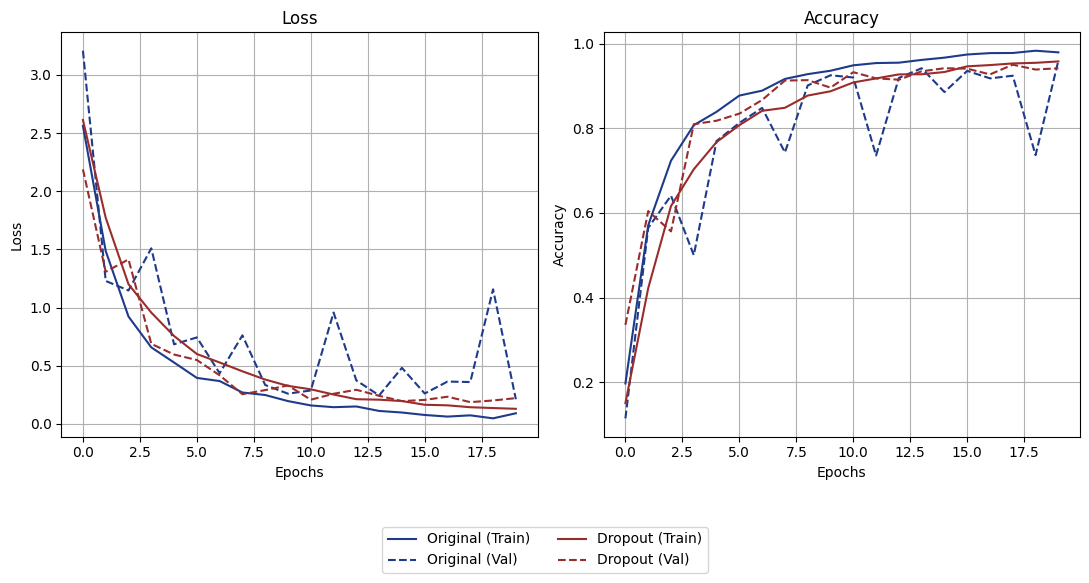

In [40]:
# Dictionary to store training histories
histories = {
    "Original": history_deep,
    "Dropout": history_dropout
}

# Visualizing accuracy and loss
plot_training_histories(histories)

With this strategy, we can see that the overfitting problem is resolved much more **effectively**, as the training and validation curves now align much better. Although this approach slightly decreases the model's accuracy, we believe it's worth it because it results in a model that generalizes the data more effectively.

---
### ***Fine-tuning*** - Using data from the 50-80 cm interval

So far, the best results we've achieved come from the model with more layers, the **Deep model**, combined with the addition of **dropout** layers to prevent overfitting. Based on this model, we've decided to perform **fine-tuning** using the data corresponding to measurements taken at a distance of **50 to 80 cm**. Since these are the data with the highest SNR, and the ones the model classifies best, we want to see if this approach helps the model better learn the characteristics of the images, potentially resulting in a more accurate model. To achieve this, the first step will be to filter the images, both from the training and validation sets, that were acquired at the specified distance.

In [41]:
# Filter training images and labels for the 050_080 interval in the training images
mask_train = (interv_training[0:train_size] == '050_080')
train_img_50_80 = train_img[mask_train]
train_labels_50_80 = train_labels[mask_train]

# Filter validation images and labels for the 050_080 interval in the validation images
mask_val = (interv_training[train_size:train_size + val_size] == '050_080')
val_img_50_80 = val_img[mask_val]
val_labels_50_80 = val_labels[mask_val]

# Verify that the images have been correctly filtered
print(f'Training images in the 050_080 interval: {len(train_img_50_80)}')
print(f'Validation images in the 050_080 interval: {len(val_img_50_80)}')


Training images in the 050_080 interval: 1128
Validation images in the 050_080 interval: 324


Once we have filtered the images of interest for this case, we will perform **fine-tuning**. To do this, we will start with the model previously trained with dropout and train it for **20 more epochs**, but using only the images acquired at a distance of 50-80 cm.

In [ ]:
# Load the model
model_dropout_tuned = keras.models.load_model(path_files + 'models/model_dropout.h5')

# Load the model weights
model_dropout_tuned.load_weights(path_files + 'models/model_dropout.weights.h5')

# Load the model's training history
with open(path_files + 'logs/history_dropout.pkl', 'rb') as f:
    history_dropout_tuned = pickle.load(f)

# Freeze all convolutional layers (except the last 4 layers)
for layer in model_dropout_tuned.layers[:-4]:  # Freeze all but the last 4 layers
    layer.trainable = False

# Recompile the model after modifying 'trainable' layers
model_dropout_tuned.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

# Train the model with the new data (50-80 cm distance)
history_dropout_tuned = model_dropout_tuned.fit(train_img_50_80,
                                                train_labels_50_80,
                                                epochs=40,
                                                batch_size=128,
                                                validation_data=(val_img_50_80, val_labels_50_80),
                                                initial_epoch=20)

# Save the fine-tuned model
model_dropout_tuned.save(path_files + 'models/model_dropout_tuned.h5')

# Save the training history
with open(path_files + 'logs/history_dropout_tuned.pkl', 'wb') as f:
    pickle.dump(history_dropout_tuned.history, f)

In [ ]:
# Load the model
model_dropout_tuned = keras.models.load_model(path_files + 'models/model_dropout_tuned.h5')

# Loading the models histories
with open(path_files + 'logs/history_dropout_tuned.pkl', 'rb') as f:
    history_dropout_tuned = pickle.load(f)

# Getting the max validation accuracy from each loaded history
model_dropout_tuned_acc = max(history_dropout_tuned['val_accuracy'])

Vamos a entrenar también el modelo Deep con el dropout,  sin en fine-tuning, 20 épocas más, para poder comparar correctamente las métricas del modelo tuneado y sin tunear

In [ ]:
# Load the model
model_dropout_40epochs = keras.models.load_model(path_files + 'models/model_dropout.h5')

# Load the model weights
model_dropout_40epochs.load_weights(path_files + 'models/model_dropout.weights.h5')

# Load the model's training history
with open(path_files + 'logs/history_dropout.pkl', 'rb') as f:
    history_dropout_40epochs = pickle.load(f)

# Ensure the model is compiled
model_dropout_40epochs.compile(loss='categorical_crossentropy',
                      optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
                      metrics=['accuracy'])

# Continue training the new epochs
history_dropout_40epochs = model_dropout_40epochs.fit(train_img, train_labels,
                                            epochs=40,
                                            batch_size=128,
                                            validation_data=(val_img, val_labels),
                                            initial_epoch=20)

# Save the model
model_dropout_40epochs.save(path_files + 'models/model_dropout_40epochs.h5')

# Save the training history
with open(path_files + 'logs/history_dropout_40epochs.pkl', 'wb') as f:
    pickle.dump(history_dropout_40epochs.history, f)

In [ ]:
# Load the model
model_dropout_40epochs = keras.models.load_model(path_files + 'models/model_dropout_40epochs.h5')

# Loading the models histories
with open(path_files + 'logs/history_dropout_40epochs.pkl', 'rb') as f:
    history_dropout_40epochs = pickle.load(f)

# Getting the max validation accuracy from each loaded history
history_dropout_40epochs_acc = max(history_dropout_40epochs['val_accuracy'])

Combinaremos los historiales de entrenamiento previo (de las 20 primeras épocas) con los nuevos (de las 20 nuevas épocas), con el fin de visualizar correctamente todo el proceso de entrenamiento

In [46]:
# History combination
history_dropout_tuned_combined = {
    'loss': history_dropout['loss'] + history_dropout_tuned['loss'],
    'val_loss': history_dropout['val_loss'] + history_dropout_tuned['val_loss'],
    'accuracy': history_dropout['accuracy'] + history_dropout_tuned['accuracy'],
    'val_accuracy': history_dropout['val_accuracy'] + history_dropout_tuned['val_accuracy']
}

history_dropout_40epochs_combined = {
    'loss': history_dropout['loss'] + history_dropout_40epochs['loss'],
    'val_loss': history_dropout['val_loss'] + history_dropout_40epochs['val_loss'],
    'accuracy': history_dropout['accuracy'] + history_dropout_40epochs['accuracy'],
    'val_accuracy': history_dropout['val_accuracy'] + history_dropout_40epochs['val_accuracy']
}

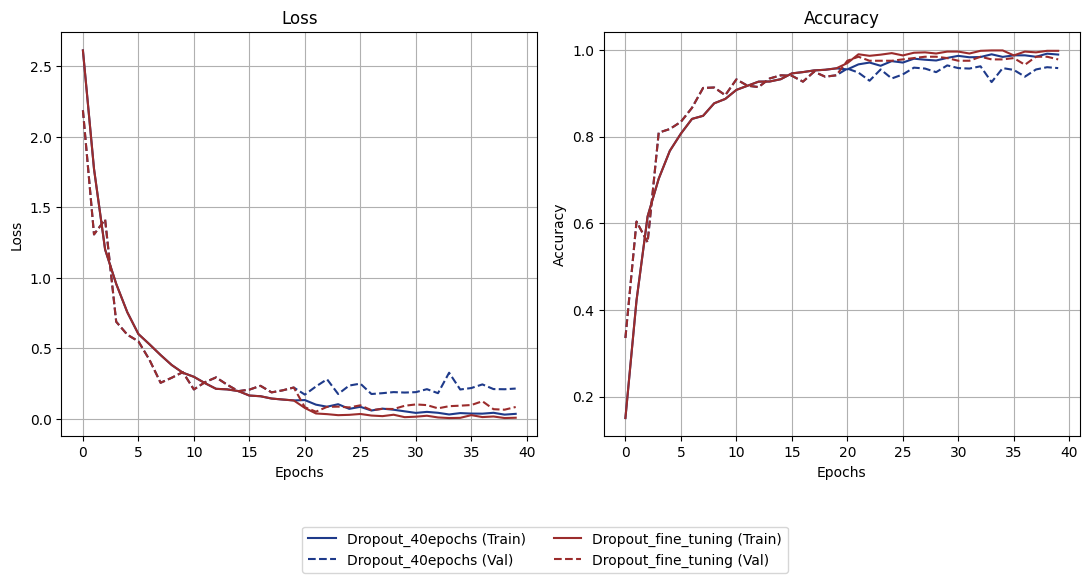

In [47]:
# Dictionary to store training histories
histories = {
    "Dropout_40epochs": history_dropout_40epochs_combined,
    "Dropout_fine_tuning": history_dropout_tuned_combined
}

# Visualizing accuracy and loss
plot_training_histories(histories)

We can confirm through the graphs that this strategy **improves the model's accuracy**, and apparently, overfitting is not occurring. Throughout the training process, we have been tracking and saving the maximum accuracy value on the validation set. When comparing these results across all the models:

In [48]:
# Accuracy data
model_accuracies = {
    "Simple": model_simple_acc,
    "Intermediate": model_intermediate_acc,
    "Deep": model_deep_acc,
    "L2 Regularization": model_l2_acc,
    "Dropout": model_dropout_acc,
    "Tuned 50-80cm Data": model_dropout_tuned_acc,
}

# Create a DataFrame
df = pd.DataFrame({
    "Model": list(model_accuracies.keys()),
    "Accuracy": list(model_accuracies.values())
})

# Sort by accuracy in descending order
df = df.sort_values("Accuracy", ascending=False)

# Display the resulting table
df

,Model,Accuracy
5,Tuned 50-80cm Data,0.984568
2,Deep,0.959375
3,L2 Regularization,0.957292
1,Intermediate,0.956250
4,Dropout,0.950000
0,Simple,0.917708


The table shows that, so far, the best model achieved is the one based on the **deeper** architecture, with **dropout** applied, and **fine-tuned** using data acquired at a distance of 50-80 cm.

Next, we will test another strategy: **transfer learning**, which involves using pre-trained models with their weights and fine-tuning them on our own dataset.

---
### Transfer Learning

As mentioned, **Transfer Learning** involves using pre-trained models on a different dataset and applying their weights to our own images. After this, various strategies can be employed, such as **fine-tuning**, where the last layers of the model are trained on our data to achieve better adaptation.

The two models we decided to use are **ResNet50** and **EfficientNet**, as they are frequently mentioned in the literature for image classification tasks. Both models were imported through Keras.

Before implementing this strategy, both models require RGB images as input, meaning images with three channels. Therefore, we decided to replicate our images across three channels to ensure compatibility with these models.

In [49]:
# Convert the images to RGB format
# First, we add the channel axis to each image so that it has the shape (4800, 1601, 57, 1)
train_img_expanded = np.expand_dims(train_img, axis=-1)
val_img_expanded = np.expand_dims(val_img, axis=-1)

# Now, we replicate this channel across the 3 RGB channels
train_img_rgb = np.repeat(train_img_expanded, 3, axis=-1)
val_img_rgb = np.repeat(val_img_expanded, 3, axis=-1)


***ResNet-50***

ResNet (Residual Networks) was one of the winners of the [ILSVRC](https://learnopencv.com/image-classification-pretrained-imagenet-models-tensorflow-keras/#Pre-Trained-models-in-Keras) competition. It is a deep learning architecture designed to address the vanishing gradient problem in very deep neural networks. ResNet introduces residual connections, or shortcut connections, that allow the network to skip one or more layers. This enables the model to learn residual mappings instead of direct mappings, helping preserve important information throughout the network. By allowing gradients to flow more effectively during training, ResNet enables the construction of much deeper models, making it particularly effective for image classification tasks and other complex problems. We will begin by using the pre-trained models provided by [Keras](https://keras.io/api/applications/resnet/) on ImageNet and then fine-tune them on our dataset.


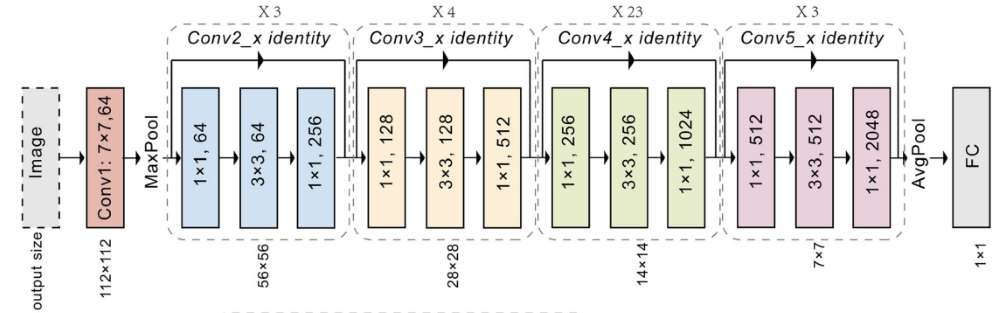

In [ ]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

# Preprocess the images to make them compatible with the network
train_img_rgb = preprocess_input(train_img_rgb)
val_img_rgb = preprocess_input(val_img_rgb)

# Initialize the ResNet50 model with pre-trained ImageNet weights (excluding the top layer)
resnet50 = ResNet50(
          include_top=False,  # Exclude the fully connected layers on top
          weights="imagenet",  # Load pre-trained weights from ImageNet
          input_tensor=None,  # No additional input tensor, using the input_shape
          input_shape=(1601, 57, 3),  # Input shape must be in the format (height, width, channels)
          pooling="max",  # Use max pooling for feature extraction
          name="resnet50")  # Name of the model

# Display the summary of the ResNet50 model
resnet50.summary()

# Freeze the convolutional base weights (keep them fixed during training)
resnet50.trainable = False

To obtain the classification of the images into the 16 labels, it is necessary to add a **Fully Connected Neural Network** (FNN) on top of the ResNet output. This will allow us to add a layer with **16 neurons** and a "**softmax**" activation function, which will enable the classification we are aiming for in the labels.

In [ ]:
# The first layer of the new model will be the 'resnet50'
model_resnet = models.Sequential()
model_resnet.add(resnet50)
model_resnet.add(layers.Flatten())
model_resnet.add(layers.Dense(512, activation='relu'))
model_resnet.add(layers.Dense(16, activation='softmax'))

model_resnet.summary()

In [ ]:
# Compiling the model and starting the training process
model_resnet.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

history_resnet= model_resnet.fit(train_img_rgb,
                                  train_labels,
                                  epochs=20,
                                  batch_size=128,
                                  validation_data=(val_img_rgb, val_labels))

# Saving the model and its history
model_resnet.save(path_files + 'models/model_resnet.h5')
with open(path_files + 'logs/history_resnet.pkl', 'wb') as f:
    pickle.dump(history_resnet.history, f)

In [ ]:
# Load the model
model_resnet = keras.models.load_model(path_files + 'models/model_resnet.h5')

# Loading the models histories
with open(path_files + 'logs/history_resnet.pkl', 'rb') as f:
    history_resnet = pickle.load(f)

# Getting the max validation accuracy from each loaded history
model_resnet_acc = max(history_resnet['val_accuracy'])

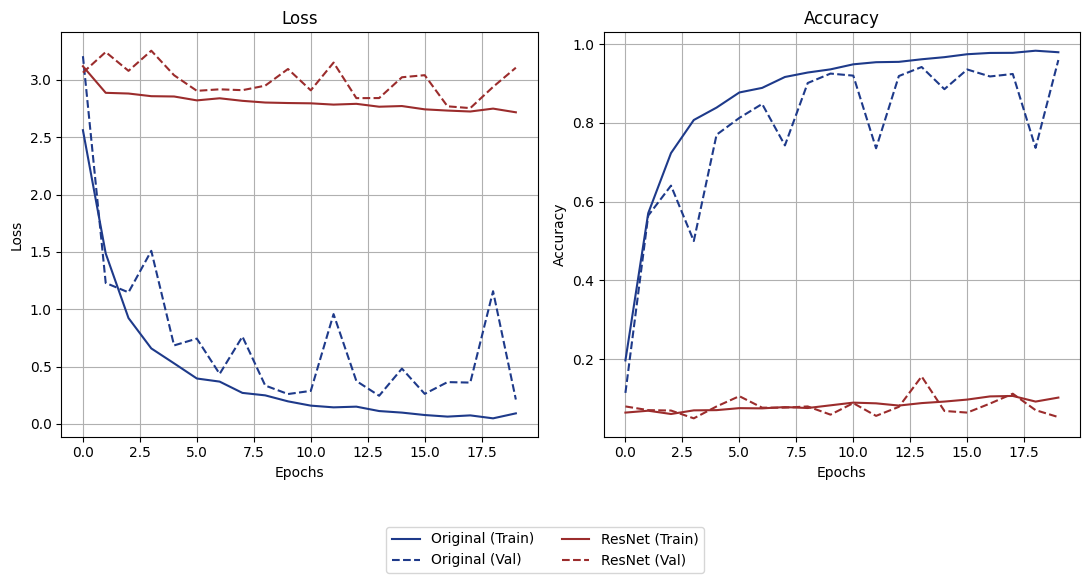

In [54]:
# Dictionary to store training histories
histories = {
    "Original": history_deep,
    "ResNet": history_resnet
}

# Visualizing accuracy and loss
plot_training_histories(histories)

The results obtained show that with the strategy used, the model's performance is **not improved**; in fact, it performs worse compared to the model previously trained with standard convolutional networks. The loss decreases slightly, indicating that the model is learning, but the accuracy remains very low. Therefore, we will try **fine-tuning **the last layers of the ResNet with our data to see if this helps the model better adapt and achieve improved results.

***Fine-Tuning ResNet50*** - Using all our Data

In [ ]:
# We will fine-tune the last convolutional block
resnet50.trainable = True

# Freeze all layers until block5, then fine-tune only block5
set_trainable = False
for layer in resnet50.layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True
    layer.trainable = set_trainable

In [ ]:
# The first layer of the new model will be the 'resnet50'
model_resnet_tuned = models.Sequential()
model_resnet_tuned.add(resnet50)
model_resnet_tuned.add(layers.Flatten())
model_resnet_tuned.add(layers.Dropout(0.5))
model_resnet_tuned.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_resnet_tuned.add(layers.Dropout(0.3))
model_resnet_tuned.add(layers.Dense(16, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

model_resnet_tuned.summary()

In [ ]:
# Compiling the model and starting the training process
model_resnet_tuned.compile(loss='categorical_crossentropy',
                            optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
                            metrics=['accuracy'])

history_resnet_tuned= model_resnet_tuned.fit(train_img_rgb,
                                  train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(val_img_rgb, val_labels))

# Saving the model and its history
model_resnet_tuned.save(path_files + 'models/model_resnet_tuned.h5')
with open(path_files + 'logs/history_resnet_tuned.pkl', 'wb') as f:
    pickle.dump(history_resnet_tuned.history, f)

In [ ]:
# Load the model
model_resnet_tuned = keras.models.load_model(path_files + 'models/model_resnet_tuned.h5')

# Loading the models histories
with open(path_files + 'logs/history_resnet_tuned.pkl', 'rb') as f:
    history_resnet_tuned = pickle.load(f)

# Getting the max validation accuracy from each loaded history
model_resnet_tuned_acc = max(history_resnet_tuned['val_accuracy'])

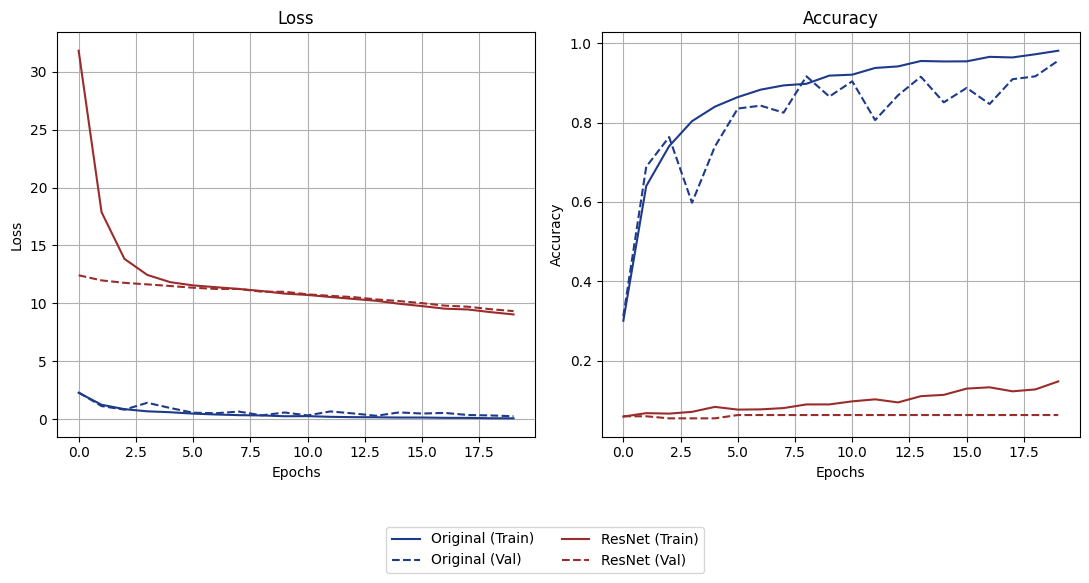

In [59]:
# Dictionary to store training histories
histories = {
    "Original": history_intermediate,
    "ResNet": history_resnet_tuned
}

# Visualizing accuracy and loss
plot_training_histories(histories)

The loss decreases slightly compared to the previous model, but the accuracy remains very low. Additionally, although it seems to start improving, we can observe that the validation accuracy is around 0.05 and does not improve. With this, we can conclude that **ResNet is not the best network for our data**. We will try another one to see if it was simply a matter of the network not being optimal for our data.

***EfficientNet***

Since the results obtained with ResNet were suboptimal, we decided to try another pre-trained network to check if the problem was that ResNet was not suitable for our data. We chose to use [EfficientNet](https://arxiv.org/abs/1905.11946), which has also been referenced in image classification tasks. We implemented it again through [Keras](https://keras.io/api/applications/efficientnet/).

EfficientNet is a family of convolutional neural network architectures designed to optimize performance and efficiency by **scaling the network in a more balanced manner**. Instead of arbitrarily increasing the depth, width, or resolution of the model, EfficientNet uses a compound scaling method that uniformly scales all three dimensions (depth, width, and resolution) to improve accuracy while maintaining computational efficiency. This allows EfficientNet to achieve state-of-the-art performance with fewer parameters and less computational cost compared to traditional architectures. Its efficiency makes it particularly well-suited for resource-constrained environments while still delivering high accuracy in tasks like **image classification**.

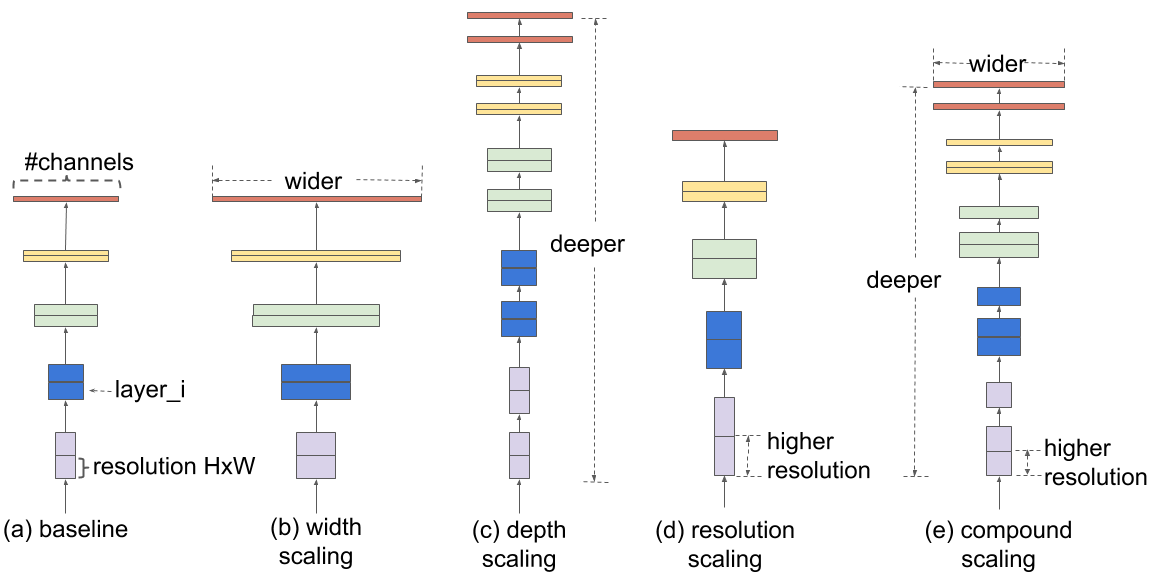

In [ ]:
from keras.applications import EfficientNetB0
from keras.applications.efficientnet import preprocess_input

# Preprocess the images to make them compatible with the network
train_img_rgb = preprocess_input(train_img_rgb)
val_img_rgb = preprocess_input(val_img_rgb)

# Initialize the EfficientNetB0 model with pre-trained ImageNet weights (excluding the top layer)
efficientnet = EfficientNetB0(
          include_top=False,
          weights="imagenet",
          input_tensor=None,
          input_shape=(1601, 57, 3),
          pooling="max")

efficientnet.summary()

# Freeze the conv. base weights
efficientnet.trainable = False

In [ ]:
# The first layer of the new model will be 'efficientnet'
model_efficientnet = models.Sequential()
model_efficientnet.add(efficientnet)
model_efficientnet.add(layers.Flatten())
model_efficientnet.add(layers.Dense(512, activation='relu'))
model_efficientnet.add(layers.Dense(512, activation='relu', kernel_regularizer='l2'))
model_efficientnet.add(layers.Dense(16, activation='softmax'))

model_efficientnet.summary()

In [ ]:
# Compiling the model and starting the training process
model_efficientnet.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

history_efficientnet= model_efficientnet.fit(train_img_rgb,
                                            train_labels,
                                            epochs=20,
                                            batch_size=128,
                                            validation_data=(val_img_rgb, val_labels))

# Saving the model and its history
model_efficientnet.save(path_files + 'models/model_efficientnet.h5')
with open(path_files + 'logs/history_efficientnet.pkl', 'wb') as f:
    pickle.dump(history_efficientnet.history, f)

In [ ]:
# Load the model
model_efficientnet = keras.models.load_model(path_files + 'models/model_efficientnet.h5')

# Loading the models histories
with open(path_files + 'logs/history_efficientnet.pkl', 'rb') as f:
    history_efficientnet = pickle.load(f)

# Getting the max validation accuracy from each loaded history
model_efficientnet_acc = max(history_efficientnet['val_accuracy'])

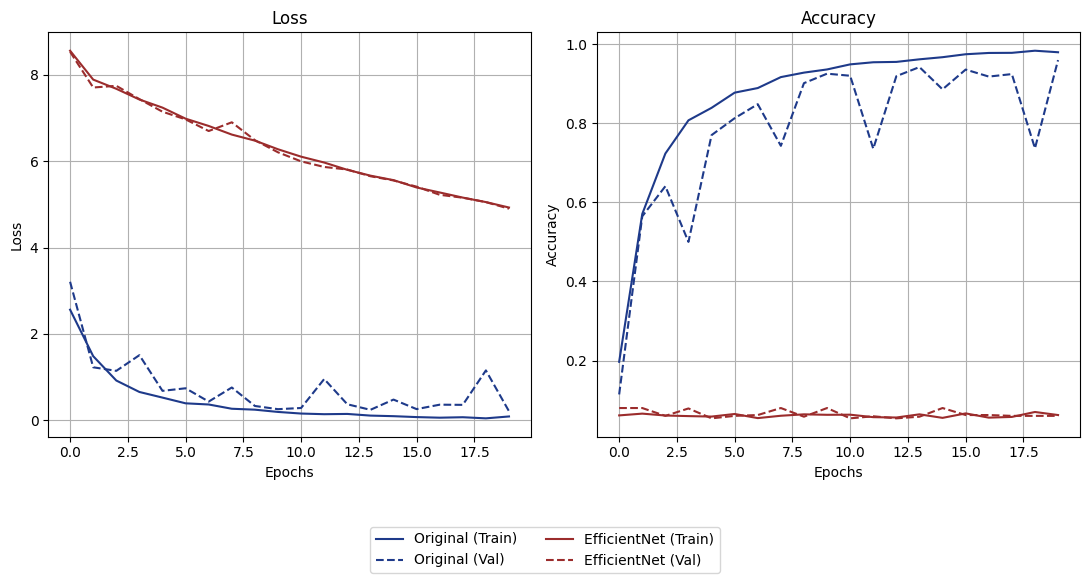

In [64]:
# Dictionary to store training histories
histories = {
    "Original": history_deep,
    "EfficientNet": history_efficientnet
}

# Visualizing accuracy and loss
plot_training_histories(histories)

We obtained the same poor results again. Although the loss starts to decrease, the accuracy values don't exceed 0.2, indicating that transfer learning might not be the best strategy for our images. However, we will try **fine-tuning** again to see if this improves the model's performance.

***Fine-Tuning EfficientNet*** - Using all our Data

In [ ]:
# We will fine-tune the last convolutional block
efficientnet.trainable = True

# Freeze all layers until block7, then fine-tune only block7
set_trainable = False
for layer in efficientnet.layers:
    if layer.name == 'block7a_expand_conv':
        set_trainable = True
    layer.trainable = set_trainable

In [ ]:
# The first layer of the new model will be 'efficientnet'
model_efficientnet_tuned = models.Sequential()
model_efficientnet_tuned.add(efficientnet)
model_efficientnet_tuned.add(layers.Flatten())
model_efficientnet_tuned.add(layers.Dropout(0.5))
model_efficientnet_tuned.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_efficientnet_tuned.add(layers.Dropout(0.3))
model_efficientnet_tuned.add(layers.Dense(16, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

model_efficientnet_tuned.summary()

In [ ]:
# Compiling the model and starting the training process
model_efficientnet_tuned.compile(loss='categorical_crossentropy',
                                  optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
                                  metrics=['accuracy'])

history_efficientnet_tuned= model_efficientnet_tuned.fit(train_img_rgb,
                                                    train_labels,
                                                    epochs=20,
                                                    batch_size=512,
                                                    validation_data=(val_img_rgb, val_labels))

# Savinng the model and its history
model_efficientnet_tuned.save(path_files + 'models/model_efficientnet_tuned.h5')
with open(path_files + 'logs/history_efficientnet_tuned.pkl', 'wb') as f:
    pickle.dump(history_efficientnet_tuned.history, f)

In [ ]:
# Load the model
model_efficientnet_tuned = keras.models.load_model(path_files + 'models/model_efficientnet_tuned.h5')

# Loading the models histories
with open(path_files + 'logs/history_efficientnet_tuned.pkl', 'rb') as f:
    history_efficientnet_tuned = pickle.load(f)

# Getting the max validation accuracy from each loaded history
model_efficientnet_tuned_acc = max(history_efficientnet_tuned['val_accuracy'])

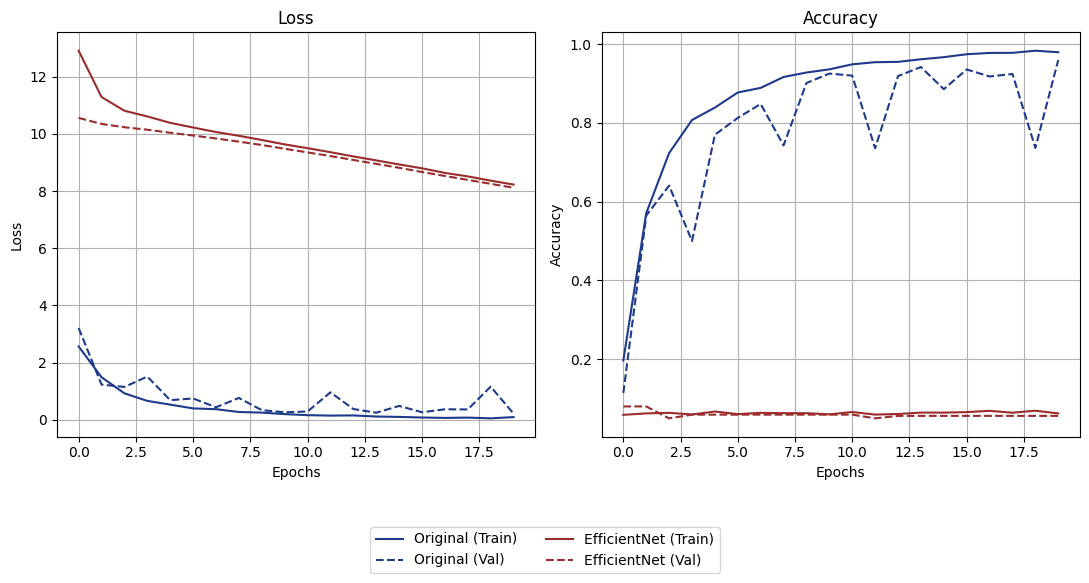

In [69]:
# Dictionary to store training histories
histories = {
    "Original": history_deep,
    "EfficientNet": history_efficientnet_tuned
}

# Visualizing accuracy and loss
plot_training_histories(histories)

Once again, with fine-tuning, we couldn't improve the model's performance. Therefore, we can conclude that this is not the best strategy for our images. This could be due to the **unusual size of our images** (1601x57) or the fact that the models are optimized for **RGB images**, while ours are grayscale.

### Selection of the Best Model

To determine which has been the **best-trained model** among the various strategies applied, we will focus on the maximum accuracy values from the validation set.

In [70]:
# Accuracy data
model_accuracies = {
    "Simple": model_simple_acc,
    "Intermediate": model_intermediate_acc,
    "Deep": model_deep_acc,
    "L2 Regularization": model_l2_acc,
    "Dropout": model_dropout_acc,
    "Dropout- Tuned 50-80cm": model_dropout_tuned_acc,
    "ResNet": model_resnet_acc,
    "ResNet - Tuned": model_resnet_tuned_acc,
    "EffectiveNet": model_efficientnet_acc,
    "EfficientNet - Tuned": model_efficientnet_tuned_acc
}

# Create a DataFrame
df = pd.DataFrame({
    "Model": list(model_accuracies.keys()),
    "Accuracy": list(model_accuracies.values())
})

# Sort by accuracy in descending order
df = df.sort_values("Accuracy", ascending=False)

# Display the resulting table
df

,Model,Accuracy
5,Dropout- Tuned 50-80cm,0.984568
2,Deep,0.959375
3,L2 Regularization,0.957292
1,Intermediate,0.956250
4,Dropout,0.950000
0,Simple,0.917708
6,ResNet,0.156250
8,EffectiveNet,0.080208
9,EfficientNet - Tuned,0.080208
7,ResNet - Tuned,0.062500


We can confirm that the best model by far is the one trained with **more convolutional layers**, applying **dropout**, and performing **fine-tuning** with the 50-80cm data. Based on this, we will conduct one final strategy.

### Training models from the Frequency Bands

The final strategy we wanted to test is to divide the images according to the **frequency bands** corresponding to a 0 or 1 (1.52, 2.3, 2.8, 3.4, 4.2, 4.99), to see if classifying each band separately, instead of the full image, leads to better performance. To do this, we will separate the images into bands and use the best model obtained so far (the deep model with dropout and fine-tuned with 50-80cm data) to perform the **classification for each band**. To implement this strategy, we need to train the model with all the new images separated by bands, and then fine-tune it with the images from the 50-80cm interval corresponding to each band.

In [71]:
# Function to split and resize bands
def split_and_resize(image, band_indices, target_height=100, target_width=57):
    bands = []
    for i in range(len(band_indices) - 1):
        start_idx = band_indices[i]
        end_idx = band_indices[i + 1]
        band = image[start_idx:end_idx, :]
        resized_band = resize(band, (target_height, target_width), preserve_range=True)
        bands.append(resized_band)
    return bands

In [72]:
# Lists to store band images and labels
images_bands = []
labels_bands = []
imges_bands_50_80 = []
labels_bands_50_80 = []

# Get the set of images acquired at a distance of 50-80cm
images_training_50_80 = np.concatenate((train_img_50_80, val_img_50_80), axis=0)

# Define the frequency bands
freq_bands = np.array([1.52, 2.3, 2.8, 3.4, 4.2, 4.99])
band_indices = [np.abs(frequences_training - freq).argmin() for freq in freq_bands]

# Convert each code to an array of integers
indv_codes = np.array([list(map(int, list(code))) for code in label_codes])

# Extract bands from the original images
for i in range(images_training_norm.shape[0]):
    # Split and resize each band
    bands = split_and_resize(images_training_norm[i], band_indices)
    images_bands.extend(bands)
    # Add labels (5 for each image)
    labels_bands.extend(indv_codes[i])

# Extract bands from the images acquired at 50-80 cm
for i in range(images_training_50_80.shape[0]):
    # Split and resize each band
    bands = split_and_resize(images_training_50_80[i], band_indices)
    imges_bands_50_80.extend(bands)
    # Add labels (5 for each image)
    labels_bands_50_80.extend(indv_codes[i])

# Convert to numpy arrays and add channel (B&W)
images_bands = np.array(images_bands).reshape(-1, 100, 57)
labels_bands = np.array(labels_bands)

images_bands_50_80 = np.array(imges_bands_50_80).reshape(-1, 100, 57)
labels_bands_50_80 = np.array(labels_bands_50_80)

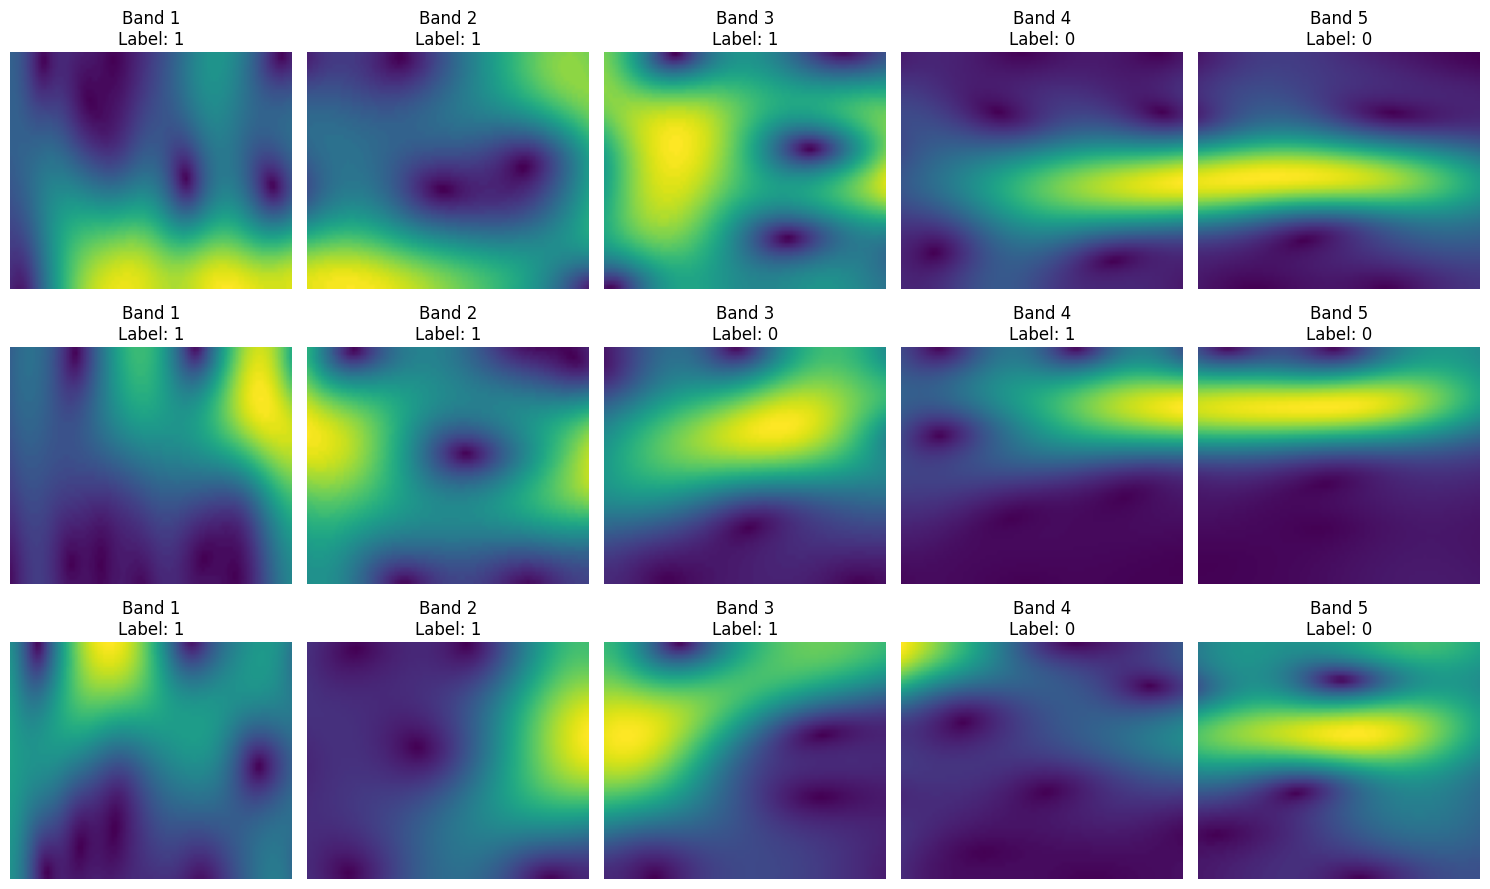

In [73]:
# Select some band images to visualize
num_examples = 3
fig, axes = plt.subplots(3, 5, figsize=(15, 3*num_examples))

for i in range(num_examples):
    bands = split_and_resize(images_training[i], band_indices)
    code = label_codes[i]

    for j in range(5):
        ax = axes[i, j] if num_examples > 1 else axes[j]
        ax.imshow(bands[j].T, cmap='viridis', aspect='auto')
        ax.set_title(f"Band {j+1}\nLabel: {code[j]}")
        ax.axis('off')

plt.tight_layout()
plt.show()

Once we have obtained the frequency band images, we now **split** them into training, validation, and test sets, just as we did with the original data.

In [74]:
total_samples = images_bands.shape[0]
total_samples_50_80 = images_bands_50_80.shape[0]

# Split into train, validation, and test sets
train_size = int(total_samples * 0.7)  # Training 70%
val_size = int(total_samples * 0.2)  # Validation 20%
test_size = total_samples - train_size - val_size  # Test 10%

train_size_50_80 = int(total_samples_50_80 * 0.7)  # Training 70%
val_size_50_80 = int(total_samples_50_80 * 0.2)  # Validation 20%
test_size_50_80 = total_samples_50_80 - train_size_50_80 - val_size_50_80  # Test 10%

# Images
train_band_img = images_bands[0:train_size]
val_band_img = images_bands[train_size:train_size + val_size]
test_band_img = images_bands[train_size + val_size:]

train_band_img_50_80 = images_bands_50_80[0:train_size_50_80]
val_band_img_50_80 = images_bands_50_80[train_size_50_80:train_size_50_80 + val_size_50_80]
test_band_img_50_80 = images_bands_50_80[train_size_50_80 + val_size_50_80:]

# Labels
train_band_labels = labels_bands[0:train_size]
val_band_labels = labels_bands[train_size:train_size + val_size]
test_band_labels = labels_bands[train_size + val_size:]

train_band_labels_50_80 = labels_bands_50_80[0:train_size_50_80]
val_band_labels_50_80 = labels_bands_50_80[train_size_50_80:train_size_50_80 + val_size_50_80]
test_band_labels_50_80 = labels_bands_50_80[train_size_50_80 + val_size_50_80:]

We will train using the best model obtained so far, which is the deep model with dropout and **fine-tuned** with the *50-80 cm* data. For the training, we must consider that the size of our images changes, now being 100x57 instead of 1601x57. Also, now, instead of classifying an image into 16 labels, it is a binary classification problem, where each image can be classified as either 0 or 1.

In [ ]:
# Modelo with Dropout
model_bands = models.Sequential()
model_bands.add(layers.Conv2D(32, (7, 7), activation='relu', padding='same', input_shape=(100,57,1)))
model_bands.add(layers.MaxPooling2D((2, 2), padding='same'))

model_bands.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model_bands.add(layers.MaxPooling2D((2, 2), padding='same'))

model_bands.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_bands.add(layers.MaxPooling2D((2, 2), padding='same'))

model_bands.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model_bands.add(layers.MaxPooling2D((2, 2), padding='same'))

model_bands.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model_bands.add(layers.MaxPooling2D((2, 2), padding='same'))

model_bands.add(layers.Flatten())
model_bands.add(layers.Dense(512, activation='relu'))
model_bands.add(layers.Dense(256, activation='relu'))
model_bands.add(layers.Dropout(0.5))  # 50% dropout
model_bands.add(layers.Dense(1, activation='sigmoid'))

model_bands.summary()

In [ ]:
# Compiling the model and starting the training process
model_bands.compile(loss='binary_crossentropy',
                    optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
                    metrics=['accuracy'])

history_bands = model_bands.fit(train_band_img,
                                train_band_labels,
                                epochs=20,
                                batch_size=128,
                                validation_data=(val_band_img, val_band_labels))

# Savinng the model and its history
model_bands.save(path_files + 'models/model_bands.h5')
with open(path_files + 'logs/history_bands.pkl', 'wb') as f:
    pickle.dump(history_bands.history, f)

In [ ]:
# Load the model
model_bands = keras.models.load_model(path_files + 'models/model_bands.h5')

# Loading the models histories
with open(path_files + 'logs/history_bands.pkl', 'rb') as f:
    history_bands = pickle.load(f)

# Getting the max validation accuracy from each loaded history
model_bands_acc = max(history_bands['val_accuracy'])

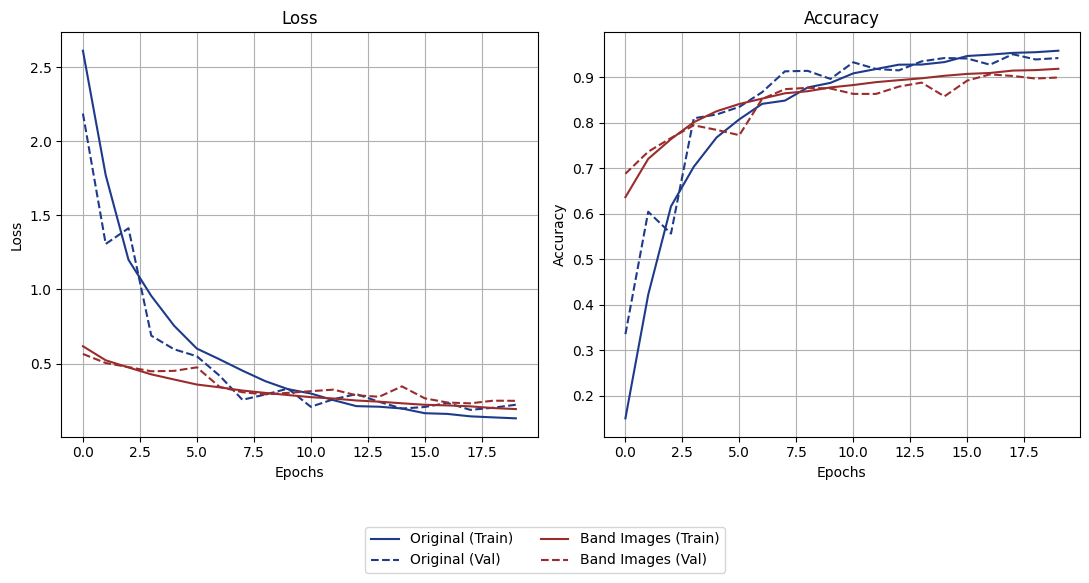

In [78]:
# Dictionary to store training histories
histories = {
    "Original": history_dropout,
    "Band Images": history_bands
}

# Visualizing accuracy and loss
plot_training_histories(histories)

With this strategy, we obtain notably good results, with accuracy starting to be quite good from very early epochs. However, the model that was previously trained with the full images, without splitting them into bands, still performs better. We will now see if **fine-tuning** improves the situation.

In [ ]:
# Load the model
model_bands_tuned = keras.models.load_model(path_files + 'models/model_bands.h5')

# Loading the models histories
with open(path_files + 'logs/history_bands.pkl', 'rb') as f:
    history_bands_tuned = pickle.load(f)

# Freeze all the convolutional layers except the last 4
for layer in model_bands_tuned.layers[:-4]:
    layer.trainable = False

# Compiling the model and starting the training process
model_bands_tuned.compile(loss='binary_crossentropy',
                          optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
                          metrics=['accuracy'])

history_bands_tuned = model_bands_tuned.fit(train_band_img_50_80,
                                            train_band_labels_50_80,
                                            epochs=40,
                                            batch_size=128,
                                            validation_data=(val_band_img_50_80, val_band_labels_50_80),
                                            initial_epoch=20)

# Savinng the model and its history
model_bands_tuned.save(path_files + 'models/model_bands_tuned.h5')
with open(path_files + 'logs/history_bands_tuned.pkl', 'wb') as f:
    pickle.dump(history_bands_tuned.history, f)

In [ ]:
# Load the model
model_bands_tuned = keras.models.load_model(path_files + 'models/model_bands_tuned.h5')

# Loading the models histories
with open(path_files + 'logs/history_bands_tuned.pkl', 'rb') as f:
    history_bands_tuned = pickle.load(f)

# Getting the max validation accuracy from each loaded history
model_bands_tuned_acc = max(history_bands_tuned['val_accuracy'])

In [81]:
# Combined histories
history_bands_tuned_combined = {
    'loss': history_bands['loss'] + history_bands_tuned['loss'],
    'val_loss': history_bands['val_loss'] + history_bands_tuned['val_loss'],
    'accuracy': history_bands['accuracy'] + history_bands_tuned['accuracy'],
    'val_accuracy': history_bands['val_accuracy'] + history_bands_tuned['val_accuracy']
}

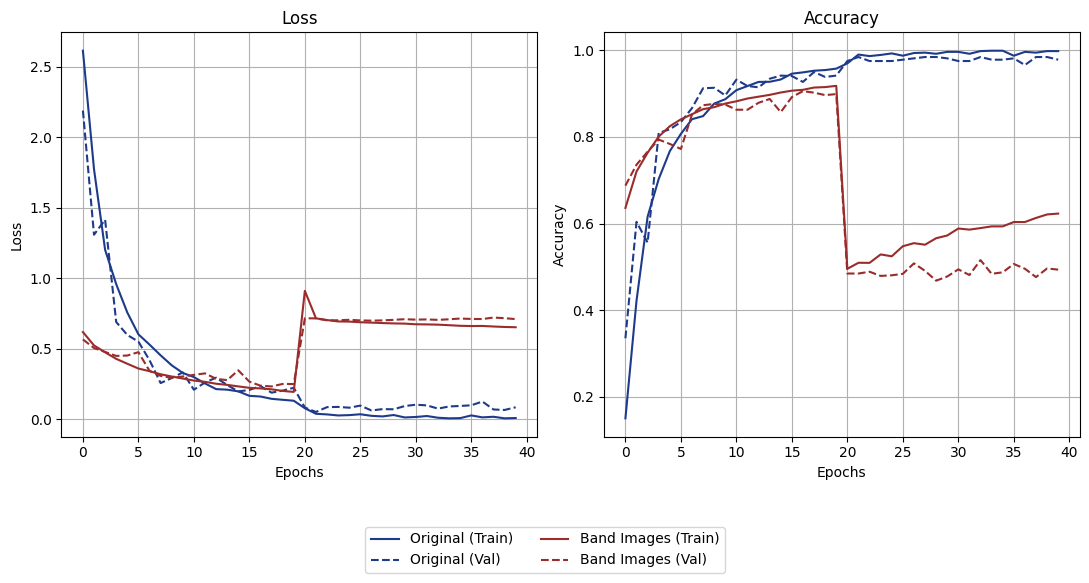

In [82]:
# Dictionary to store training histories
histories = {
    "Original": history_dropout_tuned_combined,
    "Band Images": history_bands_tuned_combined
}

# Visualizing accuracy and loss
plot_training_histories(histories)

Although we didn’t expect it, in this case, fine-tuning the model on the data acquired at 50-80 cm resulted in significantly **worse performance**. The loss increases suddenly and seems to plateau, while accuracy also drops considerably. This could be due to several factors, such as the model overfitting to the 50-80 cm dataset, the model's inability to generalize well with the new data, or the fact that fine-tuning on such a small and specific subset might not be effective for improving overall performance.

## Predictions on the test set

Once we have selected the model that has shown the best results in terms of accuracy and loss, the deep model with dropout and fine-tuning, we will make p**redictions on the test set** to see how well the model performs on data it has never seen before.

In [83]:
# Make predictions on the test set
predictions = model_dropout_tuned.predict(test_img)

# Ase the labels are in one-hot format
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Accuracy value from the predictions
test_loss, test_accuracy = model_dropout_tuned.evaluate(test_img, test_labels, batch_size=128)
print(f"Test accuracy: {test_accuracy:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9544 - loss: 0.2357
Test accuracy: 0.9583


Using the fine-tuned model with dropout, we achieve a fairly high accuracy of nearly **0.96** on the test set.

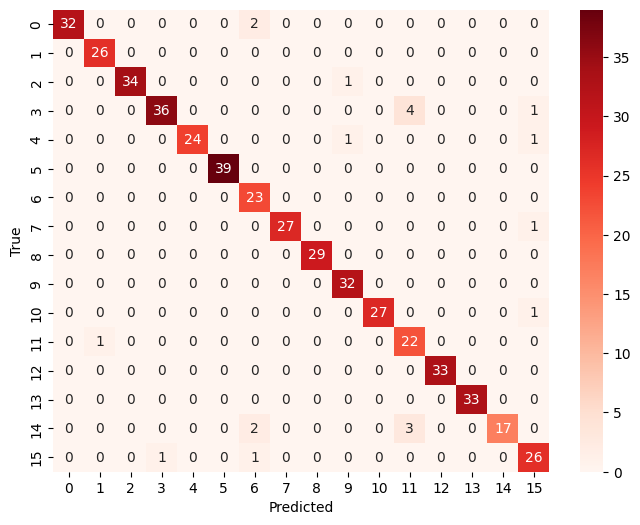

In [84]:
# Calculate the confusion matriz
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In the confusion matrix, we can see that, in general, the model classifies everything **correctly**, with only a few label misclassifications, but no more than 4 times per mistake.

On the other hand, since we were provided with a test set without labels, the following shows the predictions made with the **best model**. However, we cannot measure the accuracy or any other metric to assess how well the model performed, as we do not have the labels for these images.

In [85]:
# Make predictions on the test set
predictions = model_dropout_tuned.predict(images_test_norm)

# As the labels are in one-hot format
predicted_classes = np.argmax(predictions, axis=1)

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


We will revert the labels to their **original format**, with the size, in the form: `tag_10110_1x1`.

In [ ]:
# List with the original codes (labels without the size)
original_codes = label_codes.tolist()

# List with the original sizes
original_sizes = label_sizes.tolist()

# Reconstruct the predicted labels in the original format "tag_<code>_<size>"
predicted_labels = []
for idx in predicted_classes:
    # Find the corresponding size for each code
    predicted_label = f"tag_{original_codes[idx]}_{original_sizes[idx]}"
    predicted_labels.append(predicted_label)

# Print the first 10 predicted labels
predicted_labels